In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from Crypto.Cipher import AES
import random
from tqdm import tqdm
from collections import Counter

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rng = np.random.default_rng(SEED)            # deterministic numpy Generator
py_rng = random.Random(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"


# Load MNIST 
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(-1, 28, 28).astype(np.uint8)
test_images = test_images.reshape(-1, 28, 28).astype(np.uint8)

block_size = 4
num_blocks = (28 // block_size) ** 2 # 7x7
permutation_sequence = rng.permutation(num_blocks) # 49 
key_pool = [AES.new(bytes([py_rng.randint(0, 255) for _ in range(16)]), AES.MODE_ECB) for _ in range(1000)] # AES key pool of 1000 random AES keys

# Helper function to encrypt and permute images
def encrypt_permute_image(image, aes_key, permutation_sequence):
    encrypted_blocks = []
    for i in range(0, 28, block_size):
        for j in range(0, 28, block_size):
            block = image[i:i+block_size, j:j+block_size].flatten()
            encrypted_block = aes_key.encrypt(block.tobytes())
            encrypted_blocks.append(np.frombuffer(encrypted_block, dtype=np.uint8).reshape(block_size, block_size))
    # Apply permutation
    permuted_blocks = [encrypted_blocks[idx] for idx in permutation_sequence]
    # Reconstruct image
    permuted_image = np.zeros_like(image, dtype=np.uint8)
    idx = 0
    for i in range(0, 28, block_size):
        for j in range(0, 28, block_size):
            permuted_image[i:i+block_size, j:j+block_size] = permuted_blocks[idx]
            idx += 1
    return permuted_image

# Encrypt and permute images using encrypt_permute_image function, permutation_sequence, and randomly sampled AES keys from key_pool
def prepare_test_dataset(images, labels, key_pool, permutation_sequence, ratio=0.2):
    num_samples = int(len(images) * ratio)
    selected_indices = np.random.choice(len(images), num_samples, replace=False)
    selected_images = images[selected_indices]
    selected_labels = labels[selected_indices][:num_samples]  # Fixed to match number of samples
    
    encrypted_test_images = []
    for image in tqdm(selected_images):
        key = random.choice(key_pool)
        encrypted_image = encrypt_permute_image(image, key, permutation_sequence)
        encrypted_test_images.append(encrypted_image)
    return np.array(encrypted_test_images, dtype=np.uint8), selected_labels

# Helper: Limit to 100 images per label
def limit_images_per_label(images, labels, max_per_label=100):
    limited_indices = []
    for label in tqdm(np.unique(labels), desc="Limiting images per label"):
        indices = np.where(labels == label)[0]
        limited_indices.extend(indices[:max_per_label])
    return images[limited_indices], labels[limited_indices]

# Helper: Frequency-based cipher text replacement
def generate_replacement_cipher_map(ciphers):
    shuffled = random.sample(ciphers, len(ciphers))
    return dict(zip(ciphers, shuffled))

def cipher_replace(image, cipher_map):
    return np.vectorize(cipher_map.get)(image)

def generate_augmented_data_ciphers_replacment(images, cipher_counts, num_duplicates=40):
    cipher_keys = list(cipher_counts.keys())
    cipher_map = generate_replacement_cipher_map(cipher_keys)
    augmented_images = []
    for image in tqdm(images):
        for _ in range(num_duplicates):
            new_image = cipher_replace(image, cipher_map)
            augmented_images.append(new_image)
    return np.array(augmented_images)

# Helper: Count unique 4x4 blocks and identify most frequent block
def get_block_frequencies(image, block_size=4):
    block_counts = Counter()
    for i in range(0, image.shape[0], block_size):
        for j in range(0, image.shape[1], block_size):
            block = image[i:i+block_size, j:j+block_size].flatten()
            block_counts[tuple(block)] += 1
    most_frequent_block = max(block_counts, key=block_counts.get)
    return block_counts, most_frequent_block

# Helper: Identify black and white blocks
def identify_black_and_white_blocks(image, block_counts, most_frequent_block, block_size=4):
    black_blocks, white_blocks = [], []
    for i in range(0, image.shape[0], block_size):
        for j in range(0, image.shape[1], block_size):
            block = tuple(image[i:i+block_size, j:j+block_size].flatten())
            block_pos = (i, j)
            if block == most_frequent_block:
                black_blocks.append(block_pos)
            else:
                white_blocks.append(block_pos)
    return black_blocks, white_blocks

# Generate augmented image by replacing white blocks
def augment_image_with_replacement(image, black_blocks, white_blocks, most_frequent_block, block_size=4):
    if len(white_blocks) == 0:
        return image.copy()  # No white blocks to replace
    augmented_image = image.copy()
    num_replace = random.randint(1, min(2, len(white_blocks)))
    selected_white_blocks = random.sample(white_blocks, num_replace)
    for i, j in selected_white_blocks:
        augmented_image[i:i+block_size, j:j+block_size] = np.array(most_frequent_block).reshape(block_size, block_size)
    return augmented_image

# Function to generate 40 augmentations per image
def generate_augmented_data(images, num_augmentations=40):
    augmented_images = []
    for image in tqdm(images):
        block_counts, most_frequent_block = get_block_frequencies(image)
        black_blocks, white_blocks = identify_black_and_white_blocks(image, block_counts, most_frequent_block)
        for _ in range(num_augmentations):
            augmented_image = augment_image_with_replacement(image, black_blocks, white_blocks, most_frequent_block)
            augmented_images.append(augmented_image)
    return np.array(augmented_images)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
from Crypto.Cipher import AES
import numpy as np
import random
from collections import Counter

def get_image_block_maps(images):
    block_maps = []
    block_size = 4 
    
    for img in images:
        block_frequencies = Counter()
        
        for i in range(0, img.shape[0], block_size):
            for j in range(0, img.shape[1], block_size):
                block = img[i:i+block_size, j:j+block_size].flatten()
                block_frequencies[tuple(block)] += 1
        
        # Find most frequent block
        most_frequent_block = max(block_frequencies, key=block_frequencies.get)
        
        # Create 7x7 black and white block map
        block_map = np.zeros((7, 7), dtype=int)
        block_index = 0
        for i in range(0, 28, block_size):
            for j in range(0, 28, block_size):
                block = img[i:i+block_size, j:j+block_size].flatten()
                if tuple(block) == most_frequent_block:
                    block_map[block_index // 7, block_index % 7] = 0  # Black
                else:
                    block_map[block_index // 7, block_index % 7] = 1  # White
                block_index += 1
        
        block_maps.append(block_map)
    
    return block_maps

In [5]:
def generate_markov_block_map(block_maps, K_range=(16, 19), max_retries=50):
    new_image = np.zeros((7, 7), dtype=int)
    K = np.random.randint(K_range[0], K_range[1] + 1)  # Random K from K_range
    retries = 0
    selected_pixels = []

    # Compute initial probabilities for all pixels
    pixel_probs = {(i, j): sum(map[i, j] == 1 for map in block_maps) / len(block_maps) for i in range(7) for j in range(7)}
    initial_candidates = [(pixel, prob) for pixel, prob in pixel_probs.items() if prob > 0.60]
    
    if not initial_candidates:
        return new_image  # Return empty map if no pixel meets the initial threshold

    # Pick first pixel based on high initial probability
    first_pixel = initial_candidates[np.random.choice(len(initial_candidates))][0]
    selected_pixels.append(first_pixel)

    # Select subsequent pixels based on Markov rule
    while len(selected_pixels) < K and retries < max_retries:
        last_pixel = selected_pixels[-1]
        conditional_probs = {}
        
        for i in range(7):
            for j in range(7):
                if (i, j) not in selected_pixels:
                    count_white_given_last_white = sum(map[i, j] == 1 and map[last_pixel] == 1 for map in block_maps)
                    count_last_white = sum(map[last_pixel] == 1 for map in block_maps)
                    if count_last_white > 0:
                        conditional_probs[(i, j)] = count_white_given_last_white / count_last_white

        if conditional_probs:
            top_k_pixels = sorted(conditional_probs, key=conditional_probs.get, reverse=True)[:4]
            next_pixel = top_k_pixels[np.random.choice(len(top_k_pixels))]
            selected_pixels.append(next_pixel)
        else:
            retries += 1
            selected_pixels = [first_pixel]  # Restart with first pixel

    # Set selected pixels to white (1)
    for pixel in selected_pixels:
        new_image[pixel] = 1

    return new_image

In [4]:
def generate_augmented_block_map(block_maps, K_range=(16, 19), threshold=0.040, max_retries=50):
    selected_map = block_maps[np.random.randint(len(block_maps))]
    new_image = np.zeros((7, 7), dtype=int)
    
    retries = 0
    K = np.random.randint(K_range[0], K_range[1] + 1)  # Random K from K_range
    
    selected_pixels = []
    while len(selected_pixels) < K and retries < max_retries:
        if not selected_pixels:
            # Step 1: Pick a random white pixel from the selected map
            white_pixels = np.argwhere(selected_map == 1)
            pixel_probs = white_pixels.shape[0] / (7 * 7)
            if pixel_probs < threshold:
                continue
            selected_pixel = white_pixels[np.random.choice(len(white_pixels))]
            selected_pixels.append(tuple(selected_pixel))
        else:
            # Step 2-5: Compute conditional probabilities and select next pixel
            remaining_pixels = [tuple(idx) for idx in np.ndindex((7, 7)) if idx not in selected_pixels]
            pixel_counts = {pixel: sum(map[pixel] == 1 for map in block_maps) for pixel in remaining_pixels}
            total_counts = sum(pixel_counts.values())
            if total_counts > 0:
                pixel_probs = {pixel: count / total_counts for pixel, count in pixel_counts.items()}
                pixel_probs = {pixel: prob for pixel, prob in pixel_probs.items() if prob >= threshold}
                if pixel_probs:
                    selected_pixel = max(pixel_probs, key=pixel_probs.get)
                    selected_pixels.append(selected_pixel)
                else:
                    retries += 1
                    selected_pixels = []
                    continue
            else:
                retries += 1
                selected_pixels = []
                continue

    # Set selected pixels to white (1) and the rest to black (0)
    for pixel in selected_pixels:
        new_image[pixel] = 1
    
    return new_image

In [ ]:
def generate_augmented_block_maps(block_maps, labels):
    augmented_images = []
    augmented_labels = []
    
    for label in range(10):
        label_indices = np.where(labels == label)[0]
        label_indices = sorted(label_indices.tolist())
        start_idx = label_indices[0]
        end_idx = label_indices[-1]
        
        k_range = (10, 12)
        thr = 0.045
        if label == 1:
            k_range = (9, 10)
        elif label == 7:
            k_range = (10, 11)
        elif label == 9:
            k_range = (15, 19)
        elif label == 5:
            k_range = (10, 10)
        elif label == 0:
            k_range = (17, 19)
        elif label == 2:
            k_range = (18, 21)
        elif label == 3:
            k_range = (10, 12)
        elif label == 4:
            k_range = (14, 16)
            thr = 0.050
        elif label == 6:
            k_range = (12, 16)
        elif label == 8:
            k_range = (15, 21)
    
        err_flag=False
        num_dups = 200* (1 + (len(block_maps)-100)/1000)
        for _ in range(200):
            aug_img = generate_markov_block_map(block_maps[start_idx:end_idx+1], K_range=k_range, max_retries=50)
            aug_label = label
            
            if np.all(aug_img == 0):
                print("Something went wrong: Augmented image is all black for label: ", label)
                err_flag=True
                break
            
            if aug_img.shape != (7, 7):
                print("Something went wrong: Unexpected shape for augmented image, label: ", label)
                err_flag=True
                break
            
            augmented_images.append(aug_img)
            augmented_labels.append(aug_label)
        if err_flag:
            break
        print("Label", label, ": done.")
    
    # Convert to np.uint8 arrays
    augmented_images = np.array(augmented_images, dtype=np.uint8)
    augmented_labels = np.array(augmented_labels, dtype=np.uint8)
    
    return augmented_images, augmented_labels

In [ ]:
def generate_artificial_images(block_maps, original_images, augmented_labels):
    block_size = 4
    cipher_text_set = set()
    
    # Collect all unique cipher texts from the original 28x28 images
    for img in original_images:
        for i in range(0, img.shape[0], block_size):
            for j in range(0, img.shape[1], block_size):
                block = tuple(img[i:i+block_size, j:j+block_size].flatten())
                cipher_text_set.add(block)
                
    artificial_images = []
    
    for block_map in block_maps:
        new_image = np.zeros((28, 28), dtype=np.uint8)
        cipher_text_list = random.sample(list(cipher_text_set), 30)  # Pick 30 random cipher texts
        black_cipher_text = cipher_text_list[0]  # Reserve the first for black blocks
        white_cipher_choices = cipher_text_list[1:]  # Remaining for white blocks
        for i in range(7):
            for j in range(7):
                block_start_x, block_start_y = i * block_size, j * block_size
                if block_map[i, j] == 0:  # Black block
                    block_cipher_text = black_cipher_text
                else:  # White block
                    block_cipher_text = random.choice(white_cipher_choices)
                new_image[block_start_x:block_start_x+block_size, block_start_y:block_start_y+block_size] = np.array(block_cipher_text, dtype=np.uint8).reshape((block_size, block_size))
        artificial_images.append(new_image)
    
    return np.array(artificial_images, dtype=np.uint8), np.array(augmented_labels, dtype=np.uint8)

In [ ]:
def generate_train_test_sets(train_images, train_labels, test_images, test_labels, key_pool, permutation_sequence, train_set_size=100):
    # Randomly choose train_set_size number of images per label. These will be the train dataset given to adversary.
    train_images, train_labels = limit_images_per_label(train_images, train_labels,  train_set_size)
    
    # Encryption & Permutation
    encrypted_train_images = [encrypt_permute_image(img, random.choice(key_pool[:100]), permutation_sequence) for img in tqdm(train_images)]

    # Data Augmentation starts
    # Generate new augmented dataset and concatenate using Markov Based White Block Estimation (MWBE) 
    block_maps = get_image_block_maps(encrypted_train_images)
    augmented_block_maps, augmented_labels = generate_augmented_block_maps(block_maps, train_labels) 
    augmented_markov_images, augmented_labels = generate_artificial_images(augmented_block_maps, encrypted_train_images, augmented_labels)

    # augmentation of markov based images
    train_images_final = np.concatenate([encrypted_train_images, augmented_markov_images])
    train_labels_final = np.concatenate([train_labels, augmented_labels])
    
    num_duplicates = 10 if train_set_size>200 else 40
    
    # Generate new augmented dataset using COR 1
    cipher_counts = Counter(np.concatenate(encrypted_train_images).flatten())
    augmented_data_2 = generate_augmented_data_ciphers_replacment(encrypted_train_images, cipher_counts, num_duplicates)

    train_images_final = np.concatenate([train_images_final, augmented_data_2])
    duplicates_labels = np.repeat(train_labels, num_duplicates)
    train_labels_final = np.concatenate([train_labels_final, duplicates_labels])

    
    # Generate new augmented dataset and concatenate using COR 2
    augmented_data_3 = generate_augmented_data(encrypted_train_images, num_duplicates)
    
    # Resulting final dataset
    train_images_final = np.concatenate([train_images_final, augmented_data_3])
    train_labels_final = np.concatenate([train_labels_final, np.repeat(train_labels, num_duplicates)])
    
    print('done')
    
    # Load test images and process without augmentation
    test_images_encrypted, test_labels_encrypted = prepare_test_dataset(test_images, test_labels, key_pool[100:1000], permutation_sequence, 1.0)
    
    print('done')
    
    train_images_final=train_images_final.reshape(-1, 28, 28, 1)/255.0
    test_images_encrypted=test_images_encrypted.reshape(-1, 28, 28, 1)/255.0
    
    return train_images_final, train_labels_final, test_images_encrypted, test_labels_encrypted

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Define gradient map computation for contour extraction with 4x4 kernel
def compute_gradient_map(images):
    gx_filter = tf.constant([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=tf.float32, shape=[3, 3, 1, 1])
    gy_filter = tf.constant([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=tf.float32, shape=[3, 3, 1, 1])
    gx = tf.nn.conv2d(images, gx_filter, strides=[1, 1, 1, 1], padding='SAME')
    gy = tf.nn.conv2d(images, gy_filter, strides=[1, 1, 1, 1], padding='SAME')
    gradient_map = tf.sqrt(tf.add(tf.square(gx), tf.square(gy)))
    return gradient_map

# Define the classification model with an LSTM head
def create_cryptoeyes_model(input_shape=(28, 28, 1)):
    # First input: encrypted images
    input_images = layers.Input(shape=input_shape)
    
    # Second input: pre-computed gradient maps
    input_gradient_maps = layers.Input(shape=input_shape)
    
    # Stream for encrypted images
    conv1_enc = layers.Conv2D(32, (1, 16), padding='same')(input_images)
    conv1_enc = layers.LeakyReLU(alpha=0.01)(conv1_enc)
    gate1_enc = layers.Conv2D(32, (1, 16), activation='sigmoid', padding='same')(input_images)
    gated1_enc = layers.Multiply()([conv1_enc, gate1_enc])
    avg1_enc = layers.Average()([gated1_enc, conv1_enc])
    pool1_enc = layers.MaxPooling2D((2, 2))(avg1_enc)
    
    conv2_enc = layers.Conv2D(64, (1, 16), padding='same')(pool1_enc)
    conv2_enc = layers.LeakyReLU(alpha=0.01)(conv2_enc)
    gate2_enc = layers.Conv2D(64, (1, 16), activation='sigmoid', padding='same')(pool1_enc)
    gated2_enc = layers.Multiply()([conv2_enc, gate2_enc])
    avg2_enc = layers.Average()([gated2_enc, conv2_enc])
    pool2_enc = layers.MaxPooling2D((2, 2))(avg2_enc)
    
    flat_enc = layers.Flatten()(pool2_enc)
    
    # Stream for gradient maps
    conv1_grad = layers.Conv2D(32, (1, 16), padding='same')(input_gradient_maps)
    conv1_grad = layers.LeakyReLU(alpha=0.01)(conv1_grad)
    gate1_grad = layers.Conv2D(32, (1, 16), activation='sigmoid', padding='same')(input_gradient_maps)
    gated1_grad = layers.Multiply()([conv1_grad, gate1_grad])
    avg1_grad = layers.Average()([gated1_grad, conv1_grad])
    pool1_grad = layers.MaxPooling2D((2, 2))(avg1_grad)
    
    conv2_grad = layers.Conv2D(64, (1, 16), padding='same')(pool1_grad)
    conv2_grad = layers.LeakyReLU(alpha=0.01)(conv2_grad)
    gate2_grad = layers.Conv2D(64, (1, 16), activation='sigmoid', padding='same')(pool1_grad)
    gated2_grad = layers.Multiply()([conv2_grad, gate2_grad])
    avg2_grad = layers.Average()([gated2_grad, conv2_grad])
    pool2_grad = layers.MaxPooling2D((2, 2))(avg2_grad)
    
    flat_grad = layers.Flatten()(pool2_grad)
    
    # Combine streams
    combined = layers.Concatenate()([flat_enc, flat_grad])
    reshaped = layers.Reshape((1, -1))(combined)  # Reshape to make it compatible with LSTM

    # Optimized LSTM activation function
    lstm_layer = layers.LSTM(128, return_sequences=False)(reshaped)
    
    output = layers.Dense(10, activation='softmax')(lstm_layer)  # Adjust the number of output classes as needed
    
    model = models.Model(inputs=[input_images, input_gradient_maps], outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.00005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def __init__(self, loss_threshold=0.29, significant_drop=0.5):
        super().__init__()
        self.loss_threshold = loss_threshold
        self.significant_drop = significant_drop
        self.prev_weights = None  # Store model weights before the epoch
        self.prev_loss = float('inf')  # Track the loss from the previous epoch

    def on_epoch_begin(self, epoch, logs=None):
        # Save model weights at the start of the epoch
        self.prev_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')
        if current_loss is None:
            return  # Skip if 'loss' is not available in logs

        if current_loss < self.loss_threshold:
            print(f"Early stopping triggered at epoch {epoch + 1}. Loss: {current_loss:.4f}")
            self.model.stop_training = True

        # Check if loss has fallen significantly below the threshold
        if self.prev_loss > self.loss_threshold and current_loss < self.loss_threshold - self.significant_drop:
            print(f"Significant loss drop detected at epoch {epoch + 1}. Restoring weights from the previous epoch.")
            self.model.set_weights(self.prev_weights)  # Revert to previous epoch's weights

        self.prev_loss = current_loss

In [ ]:
def run_experiment(train_set_sizes=[10, 30, 50, 100, 500], num_trials=5):
    exp_data=[]
    for exp_trial_num in tqdm(range(1, num_trials+1, 1)):
        print("Experiment Trial Number: ",exp_trial_num, " start....")
        for train_set_size in tqdm(train_set_sizes):
            train_images_final, train_labels_final, test_images_encrypted, test_labels_encrypted = generate_train_test_sets(train_images, train_labels, test_images, test_labels, key_pool, permutation_sequence, train_set_size)
            
            input_shape = (28, 28, 1)
            model = create_cryptoeyes_model(input_shape)
            # print(model.summary())
            
            custom_callback = CustomEarlyStopping(loss_threshold=0.18, significant_drop=0.10)
            model.fit(
                [train_images_final, compute_gradient_map(train_images_final)],
                train_labels_final,
                epochs=5,
                batch_size=64,
                verbose=1,
                callbacks=[custom_callback]
            )

            test_loss, test_accuracy = model.evaluate([test_images_encrypted, compute_gradient_map(test_images_encrypted)], test_labels_encrypted, verbose=1)
            print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")
            
            exp_data.append((exp_trial_num, train_set_size, test_accuracy, test_loss))
        print("Done.")
    return exp_data

In [12]:
logs_data = run_experiment()

  0%|          | 0/5 [00:00<?, ?it/s]

Experiment Trial Number:  1  start....



  0%|          | 0/7 [00:00<?, ?it/s]

Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3713.75it/s]


100%|██████████| 100/100 [00:00<00:00, 2988.48it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/100 [00:00<?, ?it/s]

Generating level 1 augmentations:   3%|▎         | 3/100 [00:00<00:04, 23.46it/s]

Generating level 1 augmentations:   6%|▌         | 6/100 [00:00<00:04, 22.18it/s]

Generating level 1 augmentations:   9%|▉         | 9/100 [00:00<00:03, 22.78it/s]

Generating level 1 augmentations:  12%|█▏        | 12/100 [00:00<00:03, 22.40it/s]

Generating level 1 augmentations:  15%|█▌        | 15/100 [00:00<00:03, 22.98it/s]

Generating level 1 augmentations:  18%|█▊        | 18/100 [00:00<00:03, 23.14it/s]

Generating level 1 augmentations:  21%|██        | 21/100 [00:00<00:03, 23.18it/s]

Generating level 1 augmentations:  24%|██▍       | 24/100 [00:01<00:03, 22.02it/s]

Generating level 1 augmentations:  27%|██▋       | 27/100 [00:01<00:03, 22.71it/s]

Generating level 1 augmentations:  30%|███       | 30/100 [00:01<00:03, 23.16it/s]

Generating level 1 augmentations:  33%|███▎      | 33/100 [00:01<00:02, 23.54it/s]

Ge

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 330/10000 [00:00<00:02, 3299.31it/s]

  7%|▋         | 660/10000 [00:00<00:02, 3252.22it/s]

 10%|▉         | 986/10000 [00:00<00:02, 3254.43it/s]

 13%|█▎        | 1315/10000 [00:00<00:02, 3265.68it/s]

 16%|█▋        | 1642/10000 [00:00<00:02, 3219.30it/s]

 20%|█▉        | 1967/10000 [00:00<00:02, 3229.48it/s]

 23%|██▎       | 2294/10000 [00:00<00:02, 3240.36it/s]

 26%|██▋       | 2625/10000 [00:00<00:02, 3260.83it/s]

 30%|██▉       | 2952/10000 [00:00<00:02, 3235.39it/s]

 33%|███▎      | 3277/10000 [00:01<00:02, 3239.25it/s]

 36%|███▌      | 3602/10000 [00:01<00:01, 3240.96it/s]

 39%|███▉      | 3931/10000 [00:01<00:01, 3255.54it/s]

 43%|████▎     | 4263/10000 [00:01<00:01, 3268.38it/s]

 46%|████▌     | 4590/10000 [00:01<00:01, 3252.67it/s]

 49%|████▉     | 4916/10000 [00:01<00:01, 3246.09it/s]

 52%|█████▏    | 5243/10000 [00:01<00:01, 3253.01it/s]

 56%|█████▌    | 5577/10000 [00:01<00:01, 3277.12it/s]

 59%|█

done
Epoch 1/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2243 - loss: 2.2197
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7747 - loss: 1.4344
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9065 - loss: 0.5965
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9346 - loss: 0.3290
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9460 - loss: 0.2284
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3502 - loss: 2.1401



 14%|█▍        | 1/7 [00:36<03:37, 36.29s/it]

Test Accuracy: 0.3472, Test Loss: 2.1591




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3742.24it/s]


100%|██████████| 300/300 [00:00<00:00, 3355.08it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/300 [00:00<?, ?it/s]

Generating level 1 augmentations:   1%|          | 3/300 [00:00<00:12, 23.30it/s]

Generating level 1 augmentations:   2%|▏         | 6/300 [00:00<00:12, 23.28it/s]

Generating level 1 augmentations:   3%|▎         | 9/300 [00:00<00:12, 23.34it/s]

Generating level 1 augmentations:   4%|▍         | 12/300 [00:00<00:12, 23.64it/s]

Generating level 1 augmentations:   5%|▌         | 15/300 [00:00<00:12, 23.53it/s]

Generating level 1 augmentations:   6%|▌         | 18/300 [00:00<00:11, 23.51it/s]

Generating level 1 augmentations:   7%|▋         | 21/300 [00:00<00:11, 23.47it/s]

Generating level 1 augmentations:   8%|▊         | 24/300 [00:01<00:11, 23.62it/s]

Generating level 1 augmentations:   9%|▉         | 27/300 [00:01<00:11, 23.38it/s]

Generating level 1 augmentations:  10%|█         | 30/300 [00:01<00:11, 23.40it/s]

Generating level 1 augmentations:  11%|█         | 33/300 [00:01<00:12, 22.14it/s]

Ge

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 329/10000 [00:00<00:02, 3282.45it/s]

  7%|▋         | 659/10000 [00:00<00:02, 3291.86it/s]

 10%|▉         | 998/10000 [00:00<00:02, 3334.22it/s]

 13%|█▎        | 1332/10000 [00:00<00:02, 3317.23it/s]

 17%|█▋        | 1665/10000 [00:00<00:02, 3319.99it/s]

 20%|█▉        | 1998/10000 [00:00<00:02, 3278.66it/s]

 23%|██▎       | 2326/10000 [00:00<00:02, 3265.42it/s]

 27%|██▋       | 2663/10000 [00:00<00:02, 3296.07it/s]

 30%|██▉       | 2999/10000 [00:00<00:02, 3313.70it/s]

 33%|███▎      | 3333/10000 [00:01<00:02, 3320.89it/s]

 37%|███▋      | 3668/10000 [00:01<00:01, 3328.01it/s]

 40%|████      | 4001/10000 [00:01<00:01, 3310.13it/s]

 43%|████▎     | 4333/10000 [00:01<00:01, 3310.24it/s]

 47%|████▋     | 4665/10000 [00:01<00:01, 3297.06it/s]

 50%|████▉     | 4995/10000 [00:01<00:01, 3288.69it/s]

 53%|█████▎    | 5324/10000 [00:01<00:01, 3261.84it/s]

 57%|█████▋    | 5655/10000 [00:01<00:01, 3274.36it/s]

 60%|█

done
Epoch 1/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2452 - loss: 2.1664
Epoch 2/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8071 - loss: 0.9848
Epoch 3/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9448 - loss: 0.3640
Epoch 4/5
403/411 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9674 - loss: 0.1917Early stopping triggered at epoch 4. Loss: 0.1682
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9675 - loss: 0.1912
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4223 - loss: 1.8686



 29%|██▊       | 2/7 [01:35<04:10, 50.01s/it]

Test Accuracy: 0.4207, Test Loss: 1.8681




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4917.12it/s]


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 3184.71it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/500 [00:00<?, ?it/s]

Generating level 1 augmentations:   1%|          | 3/500 [00:00<00:19, 25.33it/s]

Generating level 1 augmentations:   1%|          | 6/500 [00:00<00:19, 24.89it/s]

Generating level 1 augmentations:   2%|▏         | 9/500 [00:00<00:19, 24.81it/s]

Generating level 1 augmentations:   2%|▏         | 12/500 [00:00<00:20, 24.18it/s]

Generating level 1 augmentations:   3%|▎         | 15/500 [00:00<00:20, 23.81it/s]

Generating level 1 augmentations:   4%|▎         | 18/500 [00:00<00:20, 23.60it/s]

Generating level 1 augmentations:   4%|▍         | 21/500 [00:00<00:20, 23.57it/s]

Generating level 1 augmentations:   5%|▍         | 24/500 [00:01<00:20, 23.46it/s]

Generating level 1 augmentations:   5%|▌         | 27/500 [00:01<00:20, 22.80it/s]

Generating level 1 augmentations:   6%|▌         | 30/500 [00:01<00:20, 22.89it/s]

Generating level 1 augmentations:   7%|▋         | 33/500 [00:01<00:20, 23.30it/s]

Ge

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 324/10000 [00:00<00:02, 3230.18it/s]

  6%|▋         | 648/10000 [00:00<00:03, 3093.64it/s]

 10%|▉         | 958/10000 [00:00<00:02, 3084.98it/s]

 13%|█▎        | 1267/10000 [00:00<00:02, 3021.77it/s]

 16%|█▌        | 1570/10000 [00:00<00:02, 2974.53it/s]

 19%|█▉        | 1885/10000 [00:00<00:02, 3029.09it/s]

 22%|██▏       | 2196/10000 [00:00<00:02, 3053.09it/s]

 25%|██▌       | 2502/10000 [00:00<00:02, 3034.75it/s]

 28%|██▊       | 2806/10000 [00:00<00:02, 3008.82it/s]

 31%|███       | 3110/10000 [00:01<00:02, 3017.11it/s]

 34%|███▍      | 3429/10000 [00:01<00:02, 3068.22it/s]

 37%|███▋      | 3741/10000 [00:01<00:02, 3081.77it/s]

 40%|████      | 4050/10000 [00:01<00:01, 3071.77it/s]

 44%|████▎     | 4358/10000 [00:01<00:01, 3071.89it/s]

 47%|████▋     | 4679/10000 [00:01<00:01, 3112.36it/s]

 50%|████▉     | 4995/10000 [00:01<00:01, 3123.54it/s]

 53%|█████▎    | 5314/10000 [00:01<00:01, 3142.67it/s]

 56%|█

done
Epoch 1/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3119 - loss: 2.0329
Epoch 2/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8378 - loss: 0.6774
Epoch 3/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9620 - loss: 0.2350
Epoch 4/5
660/665 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9820 - loss: 0.1082Early stopping triggered at epoch 4. Loss: 0.0984
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9820 - loss: 0.1081
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4487 - loss: 1.9567



 43%|████▎     | 3/7 [03:05<04:32, 68.13s/it]

Test Accuracy: 0.4540, Test Loss: 1.9621




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3889.74it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|██▉       | 297/1000 [00:00<00:00, 2966.45it/s]

 59%|█████▉    | 594/1000 [00:00<00:00, 2704.63it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2858.71it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 3/1000 [00:00<00:40, 24.41it/s]

Generating level 1 augmentations:   1%|          | 6/1000 [00:00<00:41, 23.73it/s]

Generating level 1 augmentations:   1%|          | 9/1000 [00:00<00:41, 23.80it/s]

Generating level 1 augmentations:   1%|          | 12/1000 [00:00<00:41, 23.82it/s]

Generating level 1 augmentations:   2%|▏         | 15/1000 [00:00<00:41, 23.58it/s]

Generating level 1 augmentations:   2%|▏         | 18/1000 [00:00<00:42, 23.13it/s]

Generating level 1 augmentations:   2%|▏         | 21/1000 [00:00<00:41, 23.36it/s]

Generating level 1 augmentations:   2%|▏         | 24/1000 [00:01<00:41, 23.37it/s]

Generating level 1 augmentations:   3%|▎         | 27/1000 [00:01<00:41, 23.32it/s]

Generating level 1 augmentations:   3%|▎         | 30/1000 [00:01<00:42, 23.08it/s]

Generating level 1 augmentations:   3%|▎         | 33/1000 [00:01<00:41, 23

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 326/10000 [00:00<00:02, 3251.92it/s]

  7%|▋         | 652/10000 [00:00<00:02, 3143.52it/s]

 10%|▉         | 969/10000 [00:00<00:02, 3154.65it/s]

 13%|█▎        | 1287/10000 [00:00<00:02, 3162.54it/s]

 16%|█▌        | 1604/10000 [00:00<00:02, 3163.05it/s]

 19%|█▉        | 1930/10000 [00:00<00:02, 3195.64it/s]

 23%|██▎       | 2258/10000 [00:00<00:02, 3222.13it/s]

 26%|██▌       | 2587/10000 [00:00<00:02, 3243.15it/s]

 29%|██▉       | 2912/10000 [00:00<00:02, 3168.91it/s]

 32%|███▏      | 3230/10000 [00:01<00:02, 3066.18it/s]

 35%|███▌      | 3545/10000 [00:01<00:02, 3090.06it/s]

 39%|███▊      | 3863/10000 [00:01<00:01, 3115.97it/s]

 42%|████▏     | 4187/10000 [00:01<00:01, 3150.22it/s]

 45%|████▌     | 4503/10000 [00:01<00:01, 3152.41it/s]

 48%|████▊     | 4819/10000 [00:01<00:01, 3138.11it/s]

 51%|█████▏    | 5145/10000 [00:01<00:01, 3171.21it/s]

 55%|█████▍    | 5469/10000 [00:01<00:01, 3189.70it/s]

 58%|█

done
Epoch 1/5
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3637 - loss: 1.8618
Epoch 2/5
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8460 - loss: 0.5808
Epoch 3/5
1290/1297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9697 - loss: 0.1796Early stopping triggered at epoch 3. Loss: 0.1416
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9698 - loss: 0.1794
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5288 - loss: 1.6702



 57%|█████▋    | 4/7 [05:43<05:10, 103.40s/it]

Test Accuracy: 0.5290, Test Loss: 1.6696




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3222.42it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

 17%|█▋        | 333/2000 [00:00<00:00, 3324.20it/s]

 33%|███▎      | 666/2000 [00:00<00:00, 3186.03it/s]

 49%|████▉     | 985/2000 [00:00<00:00, 3175.13it/s]

 66%|██████▌   | 1312/2000 [00:00<00:00, 3211.13it/s]

 82%|████████▏ | 1634/2000 [00:00<00:00, 3205.83it/s]

100%|██████████| 2000/2000 [00:00<00:00, 3191.83it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/2000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 3/2000 [00:00<01:31, 21.74it/s]

Generating level 1 augmentations:   0%|          | 6/2000 [00:00<01:29, 22.17it/s]

Generating level 1 augmentations:   0%|          | 9/2000 [00:00<01:29, 22.18it/s]

Generating level 1 augmentations:   1%|          | 12/2000 [00:00<01:30, 22.01it/s]

Generating level 1 augmentations:   1%|          | 15/2000 [00:00<01:29, 22.09it/s]

Generating level 1 augmentations:   1%|          | 18/2000 [00:00<01:28, 22.29it/s]

Generating level 1 augmentations:   1%|          | 21/2000 [00:00<01:29, 22.18it/s]

Generating level 1 augmentations:   1%|          | 24/2000 [00:01<01:29, 22.07it/s]

Generating level 1 augmentations:   1%|▏         | 27/2000 [00:01<01:30, 21.92it/s]

Generating level 1 augmentations:   2%|▏         | 30/2000 [00:01<01:30, 21.89it/s]

Generating level 1 augmentations:   2%|▏         | 33/2000 [00:01<01:31, 21

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 301/10000 [00:00<00:03, 3006.91it/s]

  6%|▌         | 602/10000 [00:00<00:03, 2994.00it/s]

  9%|▉         | 902/10000 [00:00<00:03, 2975.84it/s]

 12%|█▏        | 1200/10000 [00:00<00:02, 2935.84it/s]

 15%|█▍        | 1498/10000 [00:00<00:02, 2948.25it/s]

 18%|█▊        | 1795/10000 [00:00<00:02, 2953.39it/s]

 21%|██        | 2094/10000 [00:00<00:02, 2962.31it/s]

 24%|██▍       | 2391/10000 [00:00<00:02, 2958.29it/s]

 27%|██▋       | 2687/10000 [00:00<00:02, 2942.22it/s]

 30%|██▉       | 2982/10000 [00:01<00:02, 2917.42it/s]

 33%|███▎      | 3274/10000 [00:01<00:02, 2909.79it/s]

 36%|███▌      | 3566/10000 [00:01<00:02, 2911.96it/s]

 39%|███▊      | 3863/10000 [00:01<00:02, 2927.71it/s]

 42%|████▏     | 4160/10000 [00:01<00:01, 2938.28it/s]

 45%|████▍     | 4454/10000 [00:01<00:01, 2919.11it/s]

 47%|████▋     | 4746/10000 [00:01<00:01, 2910.86it/s]

 50%|█████     | 5039/10000 [00:01<00:01, 2915.63it/s]

 53%|█

done
Epoch 1/5
2563/2563 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.4395 - loss: 1.6179
Epoch 2/5
2563/2563 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8873 - loss: 0.4219
Epoch 3/5
2561/2563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9830 - loss: 0.0962Early stopping triggered at epoch 3. Loss: 0.0784
Significant loss drop detected at epoch 3. Restoring weights from the previous epoch.
2563/2563 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9831 - loss: 0.0962
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5524 - loss: 1.6101



 71%|███████▏  | 5/7 [10:56<05:58, 179.01s/it]

Test Accuracy: 0.5543, Test Loss: 1.6102




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3160.74it/s]


  0%|          | 0/5000 [00:00<?, ?it/s]

  6%|▌         | 304/5000 [00:00<00:01, 3033.42it/s]

 12%|█▏        | 608/5000 [00:00<00:01, 2960.29it/s]

 18%|█▊        | 905/5000 [00:00<00:01, 2936.90it/s]

 24%|██▍       | 1204/5000 [00:00<00:01, 2957.25it/s]

 30%|███       | 1504/5000 [00:00<00:01, 2972.17it/s]

 36%|███▌      | 1802/5000 [00:00<00:01, 2942.62it/s]

 42%|████▏     | 2097/5000 [00:00<00:00, 2932.70it/s]

 48%|████▊     | 2392/5000 [00:00<00:00, 2936.23it/s]

 54%|█████▍    | 2692/5000 [00:00<00:00, 2953.69it/s]

 60%|█████▉    | 2988/5000 [00:01<00:00, 2926.25it/s]

 66%|██████▌   | 3282/5000 [00:01<00:00, 2929.58it/s]

 72%|███████▏  | 3576/5000 [00:01<00:00, 2927.25it/s]

 77%|███████▋  | 3869/5000 [00:01<00:00, 2916.21it/s]

 83%|████████▎ | 4162/5000 [00:01<00:00, 2918.52it/s]

 89%|████████▉ | 4457/5000 [00:01<00:00, 2927.77it/s]

100%|██████████| 5000/5000 [00:01<00:00, 2931.04it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/5000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 9/5000 [00:00<00:55, 89.46it/s]

Generating level 1 augmentations:   0%|          | 19/5000 [00:00<00:54, 91.83it/s]

Generating level 1 augmentations:   1%|          | 29/5000 [00:00<00:54, 92.05it/s]

Generating level 1 augmentations:   1%|          | 39/5000 [00:00<00:54, 90.86it/s]

Generating level 1 augmentations:   1%|          | 49/5000 [00:00<00:56, 87.70it/s]

Generating level 1 augmentations:   1%|          | 58/5000 [00:00<00:57, 86.66it/s]

Generating level 1 augmentations:   1%|▏         | 68/5000 [00:00<00:55, 88.37it/s]

Generating level 1 augmentations:   2%|▏         | 78/5000 [00:00<00:55, 89.01it/s]

Generating level 1 augmentations:   2%|▏         | 87/5000 [00:00<00:55, 88.97it/s]

Generating level 1 augmentations:   2%|▏         | 96/5000 [00:01<00:55, 87.78it/s]

Generating level 1 augmentations:   2%|▏         | 105/5000 [00:01<00:55,

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 293/10000 [00:00<00:03, 2919.60it/s]

  6%|▌         | 585/10000 [00:00<00:03, 2867.90it/s]

  9%|▊         | 872/10000 [00:00<00:03, 2860.01it/s]

 12%|█▏        | 1162/10000 [00:00<00:03, 2874.45it/s]

 15%|█▍        | 1452/10000 [00:00<00:02, 2881.99it/s]

 17%|█▋        | 1746/10000 [00:00<00:02, 2901.43it/s]

 20%|██        | 2045/10000 [00:00<00:02, 2927.61it/s]

 23%|██▎       | 2340/10000 [00:00<00:02, 2932.66it/s]

 26%|██▋       | 2634/10000 [00:00<00:02, 2925.44it/s]

 29%|██▉       | 2927/10000 [00:01<00:02, 2913.16it/s]

 32%|███▏      | 3219/10000 [00:01<00:02, 2907.63it/s]

 35%|███▌      | 3513/10000 [00:01<00:02, 2917.04it/s]

 38%|███▊      | 3808/10000 [00:01<00:02, 2925.44it/s]

 41%|████      | 4101/10000 [00:01<00:02, 2926.44it/s]

 44%|████▍     | 4396/10000 [00:01<00:01, 2931.18it/s]

 47%|████▋     | 4690/10000 [00:01<00:01, 2910.59it/s]

 50%|████▉     | 4982/10000 [00:01<00:01, 2911.15it/s]

 53%|█

done
Epoch 1/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3587 - loss: 1.8121
Epoch 2/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6733 - loss: 0.9549
Epoch 3/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7770 - loss: 0.6882
Epoch 4/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8715 - loss: 0.4408
Epoch 5/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9385 - loss: 0.2518
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5946 - loss: 1.3939



 86%|████████▌ | 6/7 [19:28<04:52, 292.25s/it]

Test Accuracy: 0.6001, Test Loss: 1.3716




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3753.29it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 289/10000 [00:00<00:03, 2885.79it/s]

  6%|▌         | 578/10000 [00:00<00:03, 2875.88it/s]

  9%|▊         | 867/10000 [00:00<00:03, 2878.23it/s]

 12%|█▏        | 1163/10000 [00:00<00:03, 2907.80it/s]

 15%|█▍        | 1454/10000 [00:00<00:02, 2872.95it/s]

 17%|█▋        | 1742/10000 [00:00<00:02, 2861.61it/s]

 20%|██        | 2029/10000 [00:00<00:02, 2846.15it/s]

 23%|██▎       | 2319/10000 [00:00<00:02, 2861.71it/s]

 26%|██▌       | 2606/10000 [00:00<00:02, 2840.09it/s]

 29%|██▉       | 2891/10000 [00:01<00:02, 2779.16it/s]

 32%|███▏      | 3171/10000 [00:01<00:02, 2784.59it/s]

 35%|███▍      | 3460/10000 [00:01<00:02, 2815.63it/s]

 38%|███▊      | 3752/10000 [00:01<00:02, 2846.38it/s]

 40%|████      | 4043/10000 [00:01<00:02, 2862.84it/s]

 43%|████▎     | 4337/10000 [00:01<00:01, 2884.67it/s]

 46%|████▋     | 4626/10000 [00:01<00:0

Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 9/10000 [00:00<01:55, 86.40it/s]

Generating level 1 augmentations:   0%|          | 18/10000 [00:00<01:55, 86.65it/s]

Generating level 1 augmentations:   0%|          | 27/10000 [00:00<01:56, 85.94it/s]

Generating level 1 augmentations:   0%|          | 36/10000 [00:00<01:55, 86.41it/s]

Generating level 1 augmentations:   0%|          | 45/10000 [00:00<01:54, 87.26it/s]

Generating level 1 augmentations:   1%|          | 54/10000 [00:00<01:53, 87.26it/s]

Generating level 1 augmentations:   1%|          | 63/10000 [00:00<01:55, 86.22it/s]

Generating level 1 augmentations:   1%|          | 73/10000 [00:00<01:53, 87.71it/s]

Generating level 1 augmentations:   1%|          | 82/10000 [00:00<02:04, 79.47it/s]

Generating level 1 augmentations:   1%|          | 91/10000 [00:01<02:02, 81.02it/s]

Generating level 1 augmentations:   1%|          | 100/10000 [

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 311/10000 [00:00<00:03, 3103.91it/s]

  6%|▌         | 622/10000 [00:00<00:03, 2985.54it/s]

  9%|▉         | 923/10000 [00:00<00:03, 2996.06it/s]

 12%|█▏        | 1223/10000 [00:00<00:02, 2990.37it/s]

 15%|█▌        | 1534/10000 [00:00<00:02, 3029.61it/s]

 18%|█▊        | 1838/10000 [00:00<00:02, 2992.69it/s]

 21%|██▏       | 2142/10000 [00:00<00:02, 3007.71it/s]

 24%|██▍       | 2443/10000 [00:00<00:02, 2806.86it/s]

 27%|██▋       | 2749/10000 [00:00<00:02, 2881.49it/s]

 31%|███       | 3055/10000 [00:01<00:02, 2932.32it/s]

 34%|███▎      | 3365/10000 [00:01<00:02, 2980.49it/s]

 37%|███▋      | 3676/10000 [00:01<00:02, 3017.05it/s]

 40%|███▉      | 3980/10000 [00:01<00:01, 3023.63it/s]

 43%|████▎     | 4284/10000 [00:01<00:01, 2986.39it/s]

 46%|████▌     | 4584/10000 [00:01<00:01, 2963.04it/s]

 49%|████▉     | 4881/10000 [00:01<00:01, 2958.38it/s]

 52%|█████▏    | 5180/10000 [00:01<00:01, 2965.62it/s]

 55%|█

done
Epoch 1/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.4090 - loss: 1.6694
Epoch 2/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.6928 - loss: 0.9010
Epoch 3/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.7978 - loss: 0.6151
Epoch 4/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8945 - loss: 0.3541
Epoch 5/5
3304/3313 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9559 - loss: 0.1743Early stopping triggered at epoch 5. Loss: 0.1546
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9560 - loss: 0.1742
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6216 - loss: 1.4785



 20%|██        | 1/5 [36:11<2:24:46, 2171.58s/it]

Test Accuracy: 0.6220, Test Loss: 1.4751
Done.
Experiment Trial Number:  2  start....



  0%|          | 0/7 [00:00<?, ?it/s]

Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3592.24it/s]


100%|██████████| 100/100 [00:00<00:00, 2188.35it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/100 [00:00<?, ?it/s]

Generating level 1 augmentations:   3%|▎         | 3/100 [00:00<00:04, 21.84it/s]

Generating level 1 augmentations:   6%|▌         | 6/100 [00:00<00:04, 21.59it/s]

Generating level 1 augmentations:   9%|▉         | 9/100 [00:00<00:04, 21.25it/s]

Generating level 1 augmentations:  12%|█▏        | 12/100 [00:00<00:04, 21.16it/s]

Generating level 1 augmentations:  15%|█▌        | 15/100 [00:00<00:04, 21.06it/s]

Generating level 1 augmentations:  18%|█▊        | 18/100 [00:00<00:03, 21.20it/s]

Generating level 1 augmentations:  21%|██        | 21/100 [00:00<00:03, 21.30it/s]

Generating level 1 augmentations:  24%|██▍       | 24/100 [00:01<00:03, 21.36it/s]

Generating level 1 augmentations:  27%|██▋       | 27/100 [00:01<00:03, 21.48it/s]

Generating level 1 augmentations:  30%|███       | 30/100 [00:01<00:03, 21.44it/s]

Generating level 1 augmentations:  33%|███▎      | 33/100 [00:01<00:03, 21.44it/s]

Ge

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 304/10000 [00:00<00:03, 3036.83it/s]

  6%|▌         | 608/10000 [00:00<00:03, 2918.00it/s]

  9%|▉         | 904/10000 [00:00<00:03, 2932.94it/s]

 12%|█▏        | 1198/10000 [00:00<00:03, 2917.23it/s]

 15%|█▍        | 1490/10000 [00:00<00:02, 2903.40it/s]

 18%|█▊        | 1781/10000 [00:00<00:02, 2898.83it/s]

 21%|██        | 2071/10000 [00:00<00:02, 2877.75it/s]

 24%|██▎       | 2362/10000 [00:00<00:02, 2887.45it/s]

 27%|██▋       | 2661/10000 [00:00<00:02, 2918.87it/s]

 30%|██▉       | 2953/10000 [00:01<00:02, 2909.03it/s]

 33%|███▎      | 3252/10000 [00:01<00:02, 2932.10it/s]

 35%|███▌      | 3548/10000 [00:01<00:02, 2939.22it/s]

 38%|███▊      | 3842/10000 [00:01<00:02, 2929.26it/s]

 41%|████▏     | 4135/10000 [00:01<00:02, 2910.38it/s]

 44%|████▍     | 4428/10000 [00:01<00:01, 2913.73it/s]

 47%|████▋     | 4720/10000 [00:01<00:01, 2909.31it/s]

 50%|█████     | 5011/10000 [00:01<00:01, 2891.12it/s]

 53%|█

done
Epoch 1/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2101 - loss: 2.2332
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6827 - loss: 1.6249
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8726 - loss: 0.7699
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9120 - loss: 0.4212
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9387 - loss: 0.2719
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3320 - loss: 2.2067



 14%|█▍        | 1/7 [00:35<03:35, 35.91s/it]

Test Accuracy: 0.3328, Test Loss: 2.2016




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3315.13it/s]


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:00<00:00, 2803.13it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/300 [00:00<?, ?it/s]

Generating level 1 augmentations:   1%|          | 3/300 [00:00<00:13, 21.33it/s]

Generating level 1 augmentations:   2%|▏         | 6/300 [00:00<00:13, 21.29it/s]

Generating level 1 augmentations:   3%|▎         | 9/300 [00:00<00:13, 21.30it/s]

Generating level 1 augmentations:   4%|▍         | 12/300 [00:00<00:13, 21.03it/s]

Generating level 1 augmentations:   5%|▌         | 15/300 [00:00<00:13, 20.75it/s]

Generating level 1 augmentations:   6%|▌         | 18/300 [00:00<00:13, 20.85it/s]

Generating level 1 augmentations:   7%|▋         | 21/300 [00:01<00:13, 20.91it/s]

Generating level 1 augmentations:   8%|▊         | 24/300 [00:01<00:13, 21.01it/s]

Generating level 1 augmentations:   9%|▉         | 27/300 [00:01<00:12, 21.11it/s]

Generating level 1 augmentations:  10%|█         | 30/300 [00:01<00:12, 21.14it/s]

Generating level 1 augmentations:  11%|█         | 33/300 [00:01<00:12, 21.05it/s]

Ge

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 288/10000 [00:00<00:03, 2879.21it/s]

  6%|▌         | 576/10000 [00:00<00:03, 2812.57it/s]

  9%|▊         | 860/10000 [00:00<00:03, 2824.41it/s]

 11%|█▏        | 1149/10000 [00:00<00:03, 2849.60it/s]

 14%|█▍        | 1436/10000 [00:00<00:02, 2856.05it/s]

 17%|█▋        | 1728/10000 [00:00<00:02, 2874.70it/s]

 20%|██        | 2021/10000 [00:00<00:02, 2891.19it/s]

 23%|██▎       | 2311/10000 [00:00<00:02, 2870.26it/s]

 26%|██▌       | 2600/10000 [00:00<00:02, 2875.05it/s]

 29%|██▉       | 2888/10000 [00:01<00:02, 2868.57it/s]

 32%|███▏      | 3177/10000 [00:01<00:02, 2871.54it/s]

 35%|███▍      | 3465/10000 [00:01<00:02, 2861.53it/s]

 38%|███▊      | 3752/10000 [00:01<00:02, 2852.51it/s]

 40%|████      | 4040/10000 [00:01<00:02, 2857.12it/s]

 43%|████▎     | 4326/10000 [00:01<00:02, 2798.13it/s]

 46%|████▌     | 4614/10000 [00:01<00:01, 2821.24it/s]

 49%|████▉     | 4897/10000 [00:01<00:01, 2610.74it/s]

 52%|█

done
Epoch 1/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2774 - loss: 2.1302
Epoch 2/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8151 - loss: 0.8950
Epoch 3/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9470 - loss: 0.3303
Epoch 4/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9735 - loss: 0.1613Early stopping triggered at epoch 4. Loss: 0.1433
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9735 - loss: 0.1612
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4484 - loss: 1.8673



 29%|██▊       | 2/7 [01:41<04:26, 53.20s/it]

Test Accuracy: 0.4509, Test Loss: 1.8533




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4678.01it/s]


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 2855.72it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/500 [00:00<?, ?it/s]

Generating level 1 augmentations:   1%|          | 3/500 [00:00<00:22, 22.00it/s]

Generating level 1 augmentations:   1%|          | 6/500 [00:00<00:22, 22.23it/s]

Generating level 1 augmentations:   2%|▏         | 9/500 [00:00<00:22, 22.12it/s]

Generating level 1 augmentations:   2%|▏         | 12/500 [00:00<00:22, 22.17it/s]

Generating level 1 augmentations:   3%|▎         | 15/500 [00:00<00:22, 21.92it/s]

Generating level 1 augmentations:   4%|▎         | 18/500 [00:00<00:21, 22.06it/s]

Generating level 1 augmentations:   4%|▍         | 21/500 [00:00<00:21, 22.07it/s]

Generating level 1 augmentations:   5%|▍         | 24/500 [00:01<00:21, 22.16it/s]

Generating level 1 augmentations:   5%|▌         | 27/500 [00:01<00:21, 22.02it/s]

Generating level 1 augmentations:   6%|▌         | 30/500 [00:01<00:21, 21.98it/s]

Generating level 1 augmentations:   7%|▋         | 33/500 [00:01<00:21, 21.86it/s]

Ge

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 309/10000 [00:00<00:03, 3082.51it/s]

  6%|▌         | 618/10000 [00:00<00:03, 2999.84it/s]

  9%|▉         | 919/10000 [00:00<00:03, 2978.01it/s]

 12%|█▏        | 1217/10000 [00:00<00:02, 2942.80it/s]

 15%|█▌        | 1512/10000 [00:00<00:02, 2941.36it/s]

 18%|█▊        | 1808/10000 [00:00<00:02, 2945.27it/s]

 21%|██        | 2103/10000 [00:00<00:02, 2945.28it/s]

 24%|██▍       | 2402/10000 [00:00<00:02, 2958.65it/s]

 27%|██▋       | 2706/10000 [00:00<00:02, 2981.37it/s]

 30%|███       | 3008/10000 [00:01<00:02, 2992.86it/s]

 33%|███▎      | 3308/10000 [00:01<00:02, 2983.17it/s]

 36%|███▌      | 3607/10000 [00:01<00:02, 2977.77it/s]

 39%|███▉      | 3911/10000 [00:01<00:02, 2994.59it/s]

 42%|████▏     | 4211/10000 [00:01<00:01, 2989.38it/s]

 45%|████▌     | 4525/10000 [00:01<00:01, 3028.98it/s]

 48%|████▊     | 4828/10000 [00:01<00:01, 2999.27it/s]

 51%|█████▏    | 5128/10000 [00:01<00:01, 2981.26it/s]

 54%|█

done
Epoch 1/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.3117 - loss: 2.0406
Epoch 2/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8483 - loss: 0.6625
Epoch 3/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9613 - loss: 0.2355
Epoch 4/5
656/665 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9808 - loss: 0.1101Early stopping triggered at epoch 4. Loss: 0.0972
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9808 - loss: 0.1100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4702 - loss: 1.8828



 43%|████▎     | 3/7 [03:15<04:48, 72.17s/it]

Test Accuracy: 0.4656, Test Loss: 1.9090




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4246.97it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

 31%|███▏      | 314/1000 [00:00<00:00, 3138.53it/s]

 63%|██████▎   | 628/1000 [00:00<00:00, 3053.69it/s]

100%|██████████| 1000/1000 [00:00<00:00, 3004.97it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 3/1000 [00:00<00:47, 21.16it/s]

Generating level 1 augmentations:   1%|          | 6/1000 [00:00<00:45, 21.72it/s]

Generating level 1 augmentations:   1%|          | 9/1000 [00:00<00:46, 21.44it/s]

Generating level 1 augmentations:   1%|          | 12/1000 [00:00<00:45, 21.71it/s]

Generating level 1 augmentations:   2%|▏         | 15/1000 [00:00<00:44, 21.94it/s]

Generating level 1 augmentations:   2%|▏         | 18/1000 [00:00<00:44, 22.11it/s]

Generating level 1 augmentations:   2%|▏         | 21/1000 [00:00<00:44, 22.02it/s]

Generating level 1 augmentations:   2%|▏         | 24/1000 [00:01<00:44, 21.98it/s]

Generating level 1 augmentations:   3%|▎         | 27/1000 [00:01<00:43, 22.16it/s]

Generating level 1 augmentations:   3%|▎         | 30/1000 [00:01<00:43, 22.20it/s]

Generating level 1 augmentations:   3%|▎         | 33/1000 [00:01<00:44, 21

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 310/10000 [00:00<00:03, 3098.75it/s]

  6%|▌         | 620/10000 [00:00<00:03, 3004.18it/s]

  9%|▉         | 928/10000 [00:00<00:02, 3035.94it/s]

 12%|█▏        | 1234/10000 [00:00<00:02, 3044.15it/s]

 15%|█▌        | 1539/10000 [00:00<00:02, 3019.37it/s]

 18%|█▊        | 1842/10000 [00:00<00:02, 3016.43it/s]

 21%|██▏       | 2144/10000 [00:00<00:02, 3014.17it/s]

 24%|██▍       | 2446/10000 [00:00<00:02, 2995.67it/s]

 27%|██▋       | 2746/10000 [00:00<00:02, 2963.77it/s]

 30%|███       | 3043/10000 [00:01<00:02, 2959.04it/s]

 33%|███▎      | 3349/10000 [00:01<00:02, 2985.62it/s]

 37%|███▋      | 3660/10000 [00:01<00:02, 3022.87it/s]

 40%|███▉      | 3963/10000 [00:01<00:02, 3006.40it/s]

 43%|████▎     | 4278/10000 [00:01<00:01, 3048.71it/s]

 46%|████▌     | 4583/10000 [00:01<00:01, 3036.52it/s]

 49%|████▉     | 4887/10000 [00:01<00:01, 3004.93it/s]

 52%|█████▏    | 5188/10000 [00:01<00:01, 2997.94it/s]

 55%|█

done
Epoch 1/5
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3511 - loss: 1.8752
Epoch 2/5
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8612 - loss: 0.5465
Epoch 3/5
1288/1297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9756 - loss: 0.1525Early stopping triggered at epoch 3. Loss: 0.1213
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9756 - loss: 0.1522
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5009 - loss: 1.7995



 57%|█████▋    | 4/7 [05:58<05:22, 107.66s/it]

Test Accuracy: 0.5022, Test Loss: 1.7856




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3750.61it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

 15%|█▍        | 293/2000 [00:00<00:00, 2927.60it/s]

 29%|██▉       | 589/2000 [00:00<00:00, 2943.00it/s]

 44%|████▍     | 884/2000 [00:00<00:00, 2893.39it/s]

 59%|█████▊    | 1174/2000 [00:00<00:00, 2882.74it/s]

 74%|███████▍  | 1479/2000 [00:00<00:00, 2938.03it/s]

100%|██████████| 2000/2000 [00:00<00:00, 2967.52it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/2000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 3/2000 [00:00<01:26, 23.17it/s]

Generating level 1 augmentations:   0%|          | 6/2000 [00:00<01:30, 22.04it/s]

Generating level 1 augmentations:   0%|          | 9/2000 [00:00<01:29, 22.22it/s]

Generating level 1 augmentations:   1%|          | 12/2000 [00:00<01:29, 22.28it/s]

Generating level 1 augmentations:   1%|          | 15/2000 [00:00<01:28, 22.43it/s]

Generating level 1 augmentations:   1%|          | 18/2000 [00:00<01:28, 22.36it/s]

Generating level 1 augmentations:   1%|          | 21/2000 [00:00<01:28, 22.48it/s]

Generating level 1 augmentations:   1%|          | 24/2000 [00:01<01:28, 22.30it/s]

Generating level 1 augmentations:   1%|▏         | 27/2000 [00:01<01:29, 22.17it/s]

Generating level 1 augmentations:   2%|▏         | 30/2000 [00:01<01:29, 21.97it/s]

Generating level 1 augmentations:   2%|▏         | 33/2000 [00:01<01:28, 22

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 299/10000 [00:00<00:03, 2987.62it/s]

  6%|▌         | 598/10000 [00:00<00:03, 2905.75it/s]

  9%|▉         | 896/10000 [00:00<00:03, 2936.33it/s]

 12%|█▏        | 1190/10000 [00:00<00:03, 2927.43it/s]

 15%|█▍        | 1493/10000 [00:00<00:02, 2962.58it/s]

 18%|█▊        | 1804/10000 [00:00<00:02, 3009.38it/s]

 21%|██        | 2115/10000 [00:00<00:02, 3041.21it/s]

 24%|██▍       | 2420/10000 [00:00<00:02, 3021.16it/s]

 27%|██▋       | 2728/10000 [00:00<00:02, 3036.59it/s]

 30%|███       | 3038/10000 [00:01<00:02, 3055.22it/s]

 33%|███▎      | 3346/10000 [00:01<00:02, 3060.74it/s]

 37%|███▋      | 3658/10000 [00:01<00:02, 3075.36it/s]

 40%|███▉      | 3966/10000 [00:01<00:01, 3065.09it/s]

 43%|████▎     | 4277/10000 [00:01<00:01, 3076.16it/s]

 46%|████▌     | 4586/10000 [00:01<00:01, 3078.43it/s]

 49%|████▉     | 4894/10000 [00:01<00:01, 3028.50it/s]

 52%|█████▏    | 5198/10000 [00:01<00:01, 3009.51it/s]

 55%|█

done
Epoch 1/5
2563/2563 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.4216 - loss: 1.6619
Epoch 2/5
2563/2563 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8943 - loss: 0.4061
Epoch 3/5
2562/2563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9842 - loss: 0.0888Early stopping triggered at epoch 3. Loss: 0.0728
Significant loss drop detected at epoch 3. Restoring weights from the previous epoch.
2563/2563 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9842 - loss: 0.0888
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5674 - loss: 1.4916



 71%|███████▏  | 5/7 [11:06<05:59, 179.97s/it]

Test Accuracy: 0.5656, Test Loss: 1.5212




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3218.22it/s]


  0%|          | 0/5000 [00:00<?, ?it/s]

  6%|▌         | 303/5000 [00:00<00:01, 3024.99it/s]

 12%|█▏        | 606/5000 [00:00<00:01, 2940.30it/s]

 18%|█▊        | 907/5000 [00:00<00:01, 2967.89it/s]

 24%|██▍       | 1204/5000 [00:00<00:01, 2955.95it/s]

 30%|███       | 1500/5000 [00:00<00:01, 2923.16it/s]

 36%|███▌      | 1795/5000 [00:00<00:01, 2929.92it/s]

 42%|████▏     | 2089/5000 [00:00<00:00, 2915.71it/s]

 48%|████▊     | 2383/5000 [00:00<00:00, 2923.10it/s]

 54%|█████▎    | 2676/5000 [00:00<00:00, 2919.25it/s]

 59%|█████▉    | 2968/5000 [00:01<00:00, 2907.85it/s]

 65%|██████▌   | 3259/5000 [00:01<00:00, 2906.88it/s]

 71%|███████▏  | 3565/5000 [00:01<00:00, 2952.84it/s]

 77%|███████▋  | 3874/5000 [00:01<00:00, 2994.04it/s]

 84%|████████▎ | 4179/5000 [00:01<00:00, 3009.03it/s]

 90%|████████▉ | 4483/5000 [00:01<00:00, 3015.71it/s]

100%|██████████| 5000/5000 [00:01<00:00, 2966.50it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/5000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 10/5000 [00:00<00:53, 93.41it/s]

Generating level 1 augmentations:   0%|          | 20/5000 [00:00<00:55, 89.13it/s]

Generating level 1 augmentations:   1%|          | 30/5000 [00:00<00:54, 90.54it/s]

Generating level 1 augmentations:   1%|          | 40/5000 [00:00<00:55, 88.64it/s]

Generating level 1 augmentations:   1%|          | 50/5000 [00:00<00:54, 90.23it/s]

Generating level 1 augmentations:   1%|          | 60/5000 [00:00<00:54, 90.56it/s]

Generating level 1 augmentations:   1%|▏         | 70/5000 [00:00<00:54, 90.46it/s]

Generating level 1 augmentations:   2%|▏         | 80/5000 [00:00<00:53, 91.39it/s]

Generating level 1 augmentations:   2%|▏         | 90/5000 [00:00<00:53, 91.79it/s]

Generating level 1 augmentations:   2%|▏         | 100/5000 [00:01<00:53, 92.10it/s]

Generating level 1 augmentations:   2%|▏         | 110/5000 [00:01<00:5

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 310/10000 [00:00<00:03, 3090.67it/s]

  6%|▌         | 620/10000 [00:00<00:03, 3046.81it/s]

  9%|▉         | 925/10000 [00:00<00:03, 3012.26it/s]

 12%|█▏        | 1229/10000 [00:00<00:02, 3022.86it/s]

 15%|█▌        | 1535/10000 [00:00<00:02, 3032.31it/s]

 18%|█▊        | 1839/10000 [00:00<00:02, 2980.07it/s]

 21%|██▏       | 2141/10000 [00:00<00:02, 2990.70it/s]

 24%|██▍       | 2441/10000 [00:00<00:02, 2993.48it/s]

 27%|██▋       | 2741/10000 [00:00<00:02, 2979.63it/s]

 30%|███       | 3040/10000 [00:01<00:02, 2952.19it/s]

 33%|███▎      | 3336/10000 [00:01<00:02, 2947.99it/s]

 36%|███▋      | 3648/10000 [00:01<00:02, 2996.96it/s]

 40%|███▉      | 3951/10000 [00:01<00:02, 3006.46it/s]

 43%|████▎     | 4262/10000 [00:01<00:01, 3034.84it/s]

 46%|████▌     | 4567/10000 [00:01<00:01, 3036.69it/s]

 49%|████▊     | 4871/10000 [00:01<00:01, 3036.90it/s]

 52%|█████▏    | 5178/10000 [00:01<00:01, 3046.13it/s]

 55%|█

done
Epoch 1/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3553 - loss: 1.8133
Epoch 2/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6645 - loss: 0.9798
Epoch 3/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7650 - loss: 0.7125
Epoch 4/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8616 - loss: 0.4633
Epoch 5/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9318 - loss: 0.2667
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5984 - loss: 1.3718



 86%|████████▌ | 6/7 [19:24<04:48, 288.34s/it]

Test Accuracy: 0.6045, Test Loss: 1.3656




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3140.15it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 313/10000 [00:00<00:03, 3124.01it/s]

  6%|▋         | 626/10000 [00:00<00:03, 3056.64it/s]

  9%|▉         | 933/10000 [00:00<00:02, 3058.44it/s]

 12%|█▏        | 1239/10000 [00:00<00:02, 2984.47it/s]

 15%|█▌        | 1538/10000 [00:00<00:02, 2986.05it/s]

 18%|█▊        | 1837/10000 [00:00<00:02, 2946.95it/s]

 21%|██▏       | 2137/10000 [00:00<00:02, 2963.22it/s]

 24%|██▍       | 2435/10000 [00:00<00:02, 2968.18it/s]

 27%|██▋       | 2740/10000 [00:00<00:02, 2992.27it/s]

 30%|███       | 3048/10000 [00:01<00:02, 3016.97it/s]

 34%|███▎      | 3352/10000 [00:01<00:02, 3023.52it/s]

 37%|███▋      | 3662/10000 [00:01<00:02, 3045.62it/s]

 40%|███▉      | 3968/10000 [00:01<00:01, 3048.14it/s]

 43%|████▎     | 4273/10000 [00:01<00:01, 3020.42it/s]

 46%|████▌     | 4576/10000 [00:01<00:01, 3021.96it/s]

 49%|████▉     | 4879/10000 [00:01<00:0

Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 9/10000 [00:00<01:56, 86.05it/s]

Generating level 1 augmentations:   0%|          | 18/10000 [00:00<01:55, 86.22it/s]

Generating level 1 augmentations:   0%|          | 27/10000 [00:00<01:56, 85.66it/s]

Generating level 1 augmentations:   0%|          | 36/10000 [00:00<01:56, 85.46it/s]

Generating level 1 augmentations:   0%|          | 45/10000 [00:00<01:58, 84.24it/s]

Generating level 1 augmentations:   1%|          | 54/10000 [00:00<01:57, 84.94it/s]

Generating level 1 augmentations:   1%|          | 63/10000 [00:00<01:57, 84.40it/s]

Generating level 1 augmentations:   1%|          | 72/10000 [00:00<01:57, 84.58it/s]

Generating level 1 augmentations:   1%|          | 81/10000 [00:00<01:56, 85.51it/s]

Generating level 1 augmentations:   1%|          | 90/10000 [00:01<01:58, 83.90it/s]

Generating level 1 augmentations:   1%|          | 99/10000 [0

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 303/10000 [00:00<00:03, 3026.06it/s]

  6%|▌         | 606/10000 [00:00<00:03, 2916.74it/s]

  9%|▉         | 898/10000 [00:00<00:03, 2914.57it/s]

 12%|█▏        | 1190/10000 [00:00<00:03, 2901.48it/s]

 15%|█▍        | 1482/10000 [00:00<00:02, 2904.12it/s]

 18%|█▊        | 1773/10000 [00:00<00:02, 2904.96it/s]

 21%|██        | 2064/10000 [00:00<00:02, 2888.87it/s]

 24%|██▎       | 2360/10000 [00:00<00:02, 2908.91it/s]

 27%|██▋       | 2651/10000 [00:00<00:02, 2906.82it/s]

 29%|██▉       | 2945/10000 [00:01<00:02, 2916.43it/s]

 32%|███▏      | 3248/10000 [00:01<00:02, 2947.80it/s]

 35%|███▌      | 3543/10000 [00:01<00:02, 2934.38it/s]

 38%|███▊      | 3837/10000 [00:01<00:02, 2915.30it/s]

 41%|████▏     | 4129/10000 [00:01<00:02, 2908.43it/s]

 44%|████▍     | 4430/10000 [00:01<00:01, 2935.23it/s]

 47%|████▋     | 4725/10000 [00:01<00:01, 2938.19it/s]

 50%|█████     | 5020/10000 [00:01<00:01, 2939.03it/s]

 53%|█

done
Epoch 1/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.4116 - loss: 1.6531
Epoch 2/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.7001 - loss: 0.8791
Epoch 3/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8079 - loss: 0.5892
Epoch 4/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9026 - loss: 0.3327
Epoch 5/5
3312/3313 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9569 - loss: 0.1719Early stopping triggered at epoch 5. Loss: 0.1520
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9569 - loss: 0.1719
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6188 - loss: 1.4967



 40%|████      | 2/5 [1:12:04<1:48:01, 2160.63s/it]

Test Accuracy: 0.6169, Test Loss: 1.5140
Done.
Experiment Trial Number:  3  start....



  0%|          | 0/7 [00:00<?, ?it/s]

Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3732.92it/s]


100%|██████████| 100/100 [00:00<00:00, 2961.79it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/100 [00:00<?, ?it/s]

Generating level 1 augmentations:   3%|▎         | 3/100 [00:00<00:04, 21.23it/s]

Generating level 1 augmentations:   6%|▌         | 6/100 [00:00<00:04, 20.96it/s]

Generating level 1 augmentations:   9%|▉         | 9/100 [00:00<00:04, 20.96it/s]

Generating level 1 augmentations:  12%|█▏        | 12/100 [00:00<00:04, 21.06it/s]

Generating level 1 augmentations:  15%|█▌        | 15/100 [00:00<00:04, 21.13it/s]

Generating level 1 augmentations:  18%|█▊        | 18/100 [00:00<00:03, 21.31it/s]

Generating level 1 augmentations:  21%|██        | 21/100 [00:00<00:03, 21.60it/s]

Generating level 1 augmentations:  24%|██▍       | 24/100 [00:01<00:03, 21.63it/s]

Generating level 1 augmentations:  27%|██▋       | 27/100 [00:01<00:03, 21.64it/s]

Generating level 1 augmentations:  30%|███       | 30/100 [00:01<00:03, 21.49it/s]

Generating level 1 augmentations:  33%|███▎      | 33/100 [00:01<00:03, 21.40it/s]

Ge

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 294/10000 [00:00<00:03, 2930.99it/s]

  6%|▌         | 588/10000 [00:00<00:03, 2887.56it/s]

  9%|▉         | 881/10000 [00:00<00:03, 2903.87it/s]

 12%|█▏        | 1172/10000 [00:00<00:03, 2879.93it/s]

 15%|█▍        | 1463/10000 [00:00<00:02, 2889.07it/s]

 18%|█▊        | 1752/10000 [00:00<00:02, 2887.31it/s]

 20%|██        | 2041/10000 [00:00<00:02, 2886.14it/s]

 23%|██▎       | 2338/10000 [00:00<00:02, 2910.49it/s]

 26%|██▋       | 2632/10000 [00:00<00:02, 2917.05it/s]

 29%|██▉       | 2925/10000 [00:01<00:02, 2918.11it/s]

 32%|███▏      | 3217/10000 [00:01<00:02, 2896.43it/s]

 35%|███▌      | 3508/10000 [00:01<00:02, 2898.16it/s]

 38%|███▊      | 3805/10000 [00:01<00:02, 2918.84it/s]

 41%|████      | 4097/10000 [00:01<00:02, 2916.54it/s]

 44%|████▍     | 4399/10000 [00:01<00:01, 2946.17it/s]

 47%|████▋     | 4700/10000 [00:01<00:01, 2964.77it/s]

 50%|████▉     | 4997/10000 [00:01<00:01, 2930.12it/s]

 53%|█

done
Epoch 1/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1972 - loss: 2.2364
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7070 - loss: 1.5813
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8662 - loss: 0.7562
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9234 - loss: 0.3977
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9403 - loss: 0.2646
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3500 - loss: 2.0939



 14%|█▍        | 1/7 [00:35<03:30, 35.04s/it]

Test Accuracy: 0.3485, Test Loss: 2.0998




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3628.60it/s]


100%|██████████| 300/300 [00:00<00:00, 3047.50it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/300 [00:00<?, ?it/s]

Generating level 1 augmentations:   1%|          | 3/300 [00:00<00:13, 21.96it/s]

Generating level 1 augmentations:   2%|▏         | 6/300 [00:00<00:13, 21.78it/s]

Generating level 1 augmentations:   3%|▎         | 9/300 [00:00<00:13, 21.32it/s]

Generating level 1 augmentations:   4%|▍         | 12/300 [00:00<00:13, 21.17it/s]

Generating level 1 augmentations:   5%|▌         | 15/300 [00:00<00:13, 21.15it/s]

Generating level 1 augmentations:   6%|▌         | 18/300 [00:00<00:13, 21.25it/s]

Generating level 1 augmentations:   7%|▋         | 21/300 [00:00<00:13, 21.09it/s]

Generating level 1 augmentations:   8%|▊         | 24/300 [00:01<00:13, 21.19it/s]

Generating level 1 augmentations:   9%|▉         | 27/300 [00:01<00:12, 21.31it/s]

Generating level 1 augmentations:  10%|█         | 30/300 [00:01<00:12, 21.47it/s]

Generating level 1 augmentations:  11%|█         | 33/300 [00:01<00:12, 21.36it/s]

Ge

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 307/10000 [00:00<00:03, 3065.84it/s]

  6%|▌         | 614/10000 [00:00<00:03, 3029.58it/s]

  9%|▉         | 923/10000 [00:00<00:02, 3056.51it/s]

 12%|█▏        | 1229/10000 [00:00<00:02, 3047.81it/s]

 15%|█▌        | 1534/10000 [00:00<00:02, 3012.99it/s]

 18%|█▊        | 1836/10000 [00:00<00:02, 2974.77it/s]

 21%|██▏       | 2134/10000 [00:00<00:02, 2949.64it/s]

 24%|██▍       | 2430/10000 [00:00<00:02, 2939.82it/s]

 27%|██▋       | 2725/10000 [00:00<00:02, 2902.37it/s]

 30%|███       | 3016/10000 [00:01<00:02, 2888.96it/s]

 33%|███▎      | 3305/10000 [00:01<00:02, 2856.29it/s]

 36%|███▌      | 3591/10000 [00:01<00:02, 2856.56it/s]

 39%|███▉      | 3883/10000 [00:01<00:02, 2872.31it/s]

 42%|████▏     | 4171/10000 [00:01<00:02, 2836.23it/s]

 45%|████▍     | 4455/10000 [00:01<00:02, 2660.05it/s]

 47%|████▋     | 4730/10000 [00:01<00:01, 2685.17it/s]

 50%|█████     | 5019/10000 [00:01<00:01, 2741.60it/s]

 53%|█

done
Epoch 1/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2636 - loss: 2.1414
Epoch 2/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8201 - loss: 0.8381
Epoch 3/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9524 - loss: 0.3090
Epoch 4/5
403/411 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9729 - loss: 0.1568Early stopping triggered at epoch 4. Loss: 0.1396
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9729 - loss: 0.1564
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4515 - loss: 1.8391



 29%|██▊       | 2/7 [01:38<04:19, 51.99s/it]

Test Accuracy: 0.4548, Test Loss: 1.8290




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3337.29it/s]


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 2887.89it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/500 [00:00<?, ?it/s]

Generating level 1 augmentations:   1%|          | 3/500 [00:00<00:22, 21.66it/s]

Generating level 1 augmentations:   1%|          | 6/500 [00:00<00:22, 21.80it/s]

Generating level 1 augmentations:   2%|▏         | 9/500 [00:00<00:22, 21.75it/s]

Generating level 1 augmentations:   2%|▏         | 12/500 [00:00<00:22, 21.56it/s]

Generating level 1 augmentations:   3%|▎         | 15/500 [00:00<00:23, 20.21it/s]

Generating level 1 augmentations:   4%|▎         | 18/500 [00:00<00:28, 16.62it/s]

Generating level 1 augmentations:   4%|▍         | 20/500 [00:01<00:33, 14.43it/s]

Generating level 1 augmentations:   4%|▍         | 22/500 [00:01<00:36, 13.21it/s]

Generating level 1 augmentations:   5%|▍         | 24/500 [00:01<00:37, 12.69it/s]

Generating level 1 augmentations:   5%|▌         | 26/500 [00:01<00:40, 11.73it/s]

Generating level 1 augmentations:   6%|▌         | 28/500 [00:01<00:42, 11.03it/s]

Ge

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 272/10000 [00:00<00:03, 2711.48it/s]

  5%|▌         | 544/10000 [00:00<00:03, 2653.90it/s]

  8%|▊         | 810/10000 [00:00<00:03, 2418.86it/s]

 11%|█         | 1100/10000 [00:00<00:03, 2596.16it/s]

 14%|█▍        | 1385/10000 [00:00<00:03, 2682.86it/s]

 17%|█▋        | 1673/10000 [00:00<00:03, 2746.30it/s]

 20%|█▉        | 1957/10000 [00:00<00:02, 2774.03it/s]

 22%|██▏       | 2244/10000 [00:00<00:02, 2803.74it/s]

 25%|██▌       | 2533/10000 [00:00<00:02, 2829.43it/s]

 28%|██▊       | 2823/10000 [00:01<00:02, 2848.49it/s]

 31%|███       | 3113/10000 [00:01<00:02, 2863.35it/s]

 34%|███▍      | 3406/10000 [00:01<00:02, 2881.94it/s]

 37%|███▋      | 3697/10000 [00:01<00:02, 2887.56it/s]

 40%|███▉      | 3986/10000 [00:01<00:02, 2875.45it/s]

 43%|████▎     | 4274/10000 [00:01<00:01, 2875.95it/s]

 46%|████▌     | 4562/10000 [00:01<00:01, 2871.03it/s]

 48%|████▊     | 4850/10000 [00:01<00:01, 2856.15it/s]

 51%|█

done
Epoch 1/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3130 - loss: 2.0222
Epoch 2/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8543 - loss: 0.6467
Epoch 3/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9668 - loss: 0.2150Early stopping triggered at epoch 3. Loss: 0.1795
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9668 - loss: 0.2150
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4493 - loss: 1.8216



 43%|████▎     | 3/7 [03:12<04:44, 71.17s/it]

Test Accuracy: 0.4500, Test Loss: 1.8218




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4496.95it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

 29%|██▉       | 291/1000 [00:00<00:00, 2902.82it/s]

 58%|█████▊    | 582/1000 [00:00<00:00, 2872.26it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2860.54it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 3/1000 [00:00<00:46, 21.61it/s]

Generating level 1 augmentations:   1%|          | 6/1000 [00:00<00:45, 21.88it/s]

Generating level 1 augmentations:   1%|          | 9/1000 [00:00<00:44, 22.10it/s]

Generating level 1 augmentations:   1%|          | 12/1000 [00:00<00:44, 22.06it/s]

Generating level 1 augmentations:   2%|▏         | 15/1000 [00:00<00:44, 22.07it/s]

Generating level 1 augmentations:   2%|▏         | 18/1000 [00:00<00:44, 22.09it/s]

Generating level 1 augmentations:   2%|▏         | 21/1000 [00:00<00:45, 21.75it/s]

Generating level 1 augmentations:   2%|▏         | 24/1000 [00:01<00:44, 21.80it/s]

Generating level 1 augmentations:   3%|▎         | 27/1000 [00:01<00:44, 22.10it/s]

Generating level 1 augmentations:   3%|▎         | 30/1000 [00:01<00:43, 22.18it/s]

Generating level 1 augmentations:   3%|▎         | 33/1000 [00:01<00:43, 22

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 297/10000 [00:00<00:03, 2969.34it/s]

  6%|▌         | 594/10000 [00:00<00:03, 2910.60it/s]

  9%|▉         | 886/10000 [00:00<00:03, 2878.22it/s]

 12%|█▏        | 1174/10000 [00:00<00:03, 2803.03it/s]

 15%|█▍        | 1456/10000 [00:00<00:03, 2808.45it/s]

 18%|█▊        | 1750/10000 [00:00<00:02, 2851.46it/s]

 20%|██        | 2036/10000 [00:00<00:02, 2853.16it/s]

 23%|██▎       | 2322/10000 [00:00<00:02, 2832.89it/s]

 26%|██▌       | 2608/10000 [00:00<00:02, 2841.23it/s]

 29%|██▉       | 2900/10000 [00:01<00:02, 2862.63it/s]

 32%|███▏      | 3187/10000 [00:01<00:02, 2863.09it/s]

 35%|███▍      | 3474/10000 [00:01<00:02, 2864.87it/s]

 38%|███▊      | 3764/10000 [00:01<00:02, 2874.56it/s]

 41%|████      | 4056/10000 [00:01<00:02, 2886.26it/s]

 43%|████▎     | 4345/10000 [00:01<00:01, 2873.63it/s]

 46%|████▋     | 4633/10000 [00:01<00:01, 2815.25it/s]

 49%|████▉     | 4917/10000 [00:01<00:01, 2820.68it/s]

 52%|█

done
Epoch 1/5
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.3547 - loss: 1.8628
Epoch 2/5
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8447 - loss: 0.5839
Epoch 3/5
1291/1297 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9697 - loss: 0.1743Early stopping triggered at epoch 3. Loss: 0.1401
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9697 - loss: 0.1741
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5219 - loss: 1.7459



 57%|█████▋    | 4/7 [06:00<05:28, 109.35s/it]

Test Accuracy: 0.5169, Test Loss: 1.7384




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3836.02it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

 15%|█▍        | 298/2000 [00:00<00:00, 2974.00it/s]

 30%|██▉       | 596/2000 [00:00<00:00, 2858.85it/s]

 44%|████▍     | 885/2000 [00:00<00:00, 2871.87it/s]

 59%|█████▊    | 1173/2000 [00:00<00:00, 2592.04it/s]

 73%|███████▎  | 1467/2000 [00:00<00:00, 2707.27it/s]

100%|██████████| 2000/2000 [00:00<00:00, 2800.21it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/2000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 3/2000 [00:00<01:32, 21.50it/s]

Generating level 1 augmentations:   0%|          | 6/2000 [00:00<01:32, 21.46it/s]

Generating level 1 augmentations:   0%|          | 9/2000 [00:00<01:33, 21.33it/s]

Generating level 1 augmentations:   1%|          | 12/2000 [00:00<01:33, 21.23it/s]

Generating level 1 augmentations:   1%|          | 15/2000 [00:00<01:33, 21.12it/s]

Generating level 1 augmentations:   1%|          | 18/2000 [00:00<01:33, 21.21it/s]

Generating level 1 augmentations:   1%|          | 21/2000 [00:00<01:33, 21.15it/s]

Generating level 1 augmentations:   1%|          | 24/2000 [00:01<01:32, 21.27it/s]

Generating level 1 augmentations:   1%|▏         | 27/2000 [00:01<01:33, 20.99it/s]

Generating level 1 augmentations:   2%|▏         | 30/2000 [00:01<01:33, 21.11it/s]

Generating level 1 augmentations:   2%|▏         | 33/2000 [00:01<01:34, 20

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  2%|▏         | 240/10000 [00:00<00:04, 2396.76it/s]

  5%|▌         | 511/10000 [00:00<00:03, 2531.58it/s]

  8%|▊         | 782/10000 [00:00<00:03, 2608.25it/s]

 10%|█         | 1043/10000 [00:00<00:03, 2565.37it/s]

 13%|█▎        | 1300/10000 [00:00<00:03, 2552.73it/s]

 16%|█▌        | 1584/10000 [00:00<00:03, 2646.80it/s]

 19%|█▊        | 1870/10000 [00:00<00:02, 2714.35it/s]

 22%|██▏       | 2155/10000 [00:00<00:02, 2755.58it/s]

 24%|██▍       | 2434/10000 [00:00<00:02, 2765.83it/s]

 27%|██▋       | 2720/10000 [00:01<00:02, 2792.42it/s]

 30%|███       | 3000/10000 [00:01<00:02, 2745.98it/s]

 33%|███▎      | 3286/10000 [00:01<00:02, 2778.85it/s]

 36%|███▌      | 3570/10000 [00:01<00:02, 2795.26it/s]

 39%|███▊      | 3856/10000 [00:01<00:02, 2810.29it/s]

 41%|████▏     | 4141/10000 [00:01<00:02, 2821.88it/s]

 44%|████▍     | 4431/10000 [00:01<00:01, 2842.74it/s]

 47%|████▋     | 4718/10000 [00:01<00:01, 2850.11it/s]

 50%|█

done
Epoch 1/5
2563/2563 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.4366 - loss: 1.6252
Epoch 2/5
2563/2563 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9150 - loss: 0.3505
Epoch 3/5
2558/2563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9877 - loss: 0.0739Early stopping triggered at epoch 3. Loss: 0.0599
Significant loss drop detected at epoch 3. Restoring weights from the previous epoch.
2563/2563 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9877 - loss: 0.0738
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5420 - loss: 1.6185



 71%|███████▏  | 5/7 [11:23<06:12, 186.17s/it]

Test Accuracy: 0.5383, Test Loss: 1.6138




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3396.47it/s]


  0%|          | 0/5000 [00:00<?, ?it/s]

  6%|▌         | 291/5000 [00:00<00:01, 2904.98it/s]

 12%|█▏        | 582/5000 [00:00<00:01, 2859.77it/s]

 17%|█▋        | 869/5000 [00:00<00:01, 2858.71it/s]

 23%|██▎       | 1155/5000 [00:00<00:01, 2858.44it/s]

 29%|██▉       | 1441/5000 [00:00<00:01, 2853.70it/s]

 35%|███▍      | 1729/5000 [00:00<00:01, 2862.14it/s]

 40%|████      | 2016/5000 [00:00<00:01, 2856.89it/s]

 46%|████▌     | 2302/5000 [00:00<00:00, 2842.66it/s]

 52%|█████▏    | 2588/5000 [00:00<00:00, 2846.17it/s]

 57%|█████▋    | 2873/5000 [00:01<00:00, 2806.25it/s]

 63%|██████▎   | 3158/5000 [00:01<00:00, 2819.30it/s]

 69%|██████▉   | 3445/5000 [00:01<00:00, 2834.39it/s]

 75%|███████▍  | 3731/5000 [00:01<00:00, 2841.16it/s]

 80%|████████  | 4016/5000 [00:01<00:00, 2836.91it/s]

 86%|████████▌ | 4300/5000 [00:01<00:00, 2834.03it/s]

 92%|█████████▏| 4584/5000 [00:01<00:00, 2771.66it/s]



Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/5000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 7/5000 [00:00<01:15, 66.07it/s]

Generating level 1 augmentations:   0%|          | 15/5000 [00:00<01:09, 71.83it/s]

Generating level 1 augmentations:   0%|          | 24/5000 [00:00<01:03, 78.27it/s]

Generating level 1 augmentations:   1%|          | 33/5000 [00:00<01:01, 80.81it/s]

Generating level 1 augmentations:   1%|          | 42/5000 [00:00<01:00, 82.22it/s]

Generating level 1 augmentations:   1%|          | 51/5000 [00:00<00:59, 82.64it/s]

Generating level 1 augmentations:   1%|          | 60/5000 [00:00<00:59, 83.16it/s]

Generating level 1 augmentations:   1%|▏         | 69/5000 [00:00<00:58, 83.70it/s]

Generating level 1 augmentations:   2%|▏         | 78/5000 [00:00<00:58, 83.82it/s]

Generating level 1 augmentations:   2%|▏         | 87/5000 [00:01<00:59, 83.06it/s]

Generating level 1 augmentations:   2%|▏         | 96/5000 [00:01<00:59, 

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 296/10000 [00:00<00:03, 2953.97it/s]

  6%|▌         | 595/10000 [00:00<00:03, 2973.92it/s]

  9%|▉         | 893/10000 [00:00<00:03, 2974.89it/s]

 12%|█▏        | 1191/10000 [00:00<00:02, 2971.12it/s]

 15%|█▍        | 1489/10000 [00:00<00:02, 2925.76it/s]

 18%|█▊        | 1782/10000 [00:00<00:02, 2858.81it/s]

 21%|██        | 2072/10000 [00:00<00:02, 2871.39it/s]

 24%|██▎       | 2360/10000 [00:00<00:02, 2862.60it/s]

 26%|██▋       | 2650/10000 [00:00<00:02, 2871.14it/s]

 29%|██▉       | 2942/10000 [00:01<00:02, 2885.68it/s]

 32%|███▏      | 3234/10000 [00:01<00:02, 2895.17it/s]

 35%|███▌      | 3524/10000 [00:01<00:02, 2893.66it/s]

 38%|███▊      | 3815/10000 [00:01<00:02, 2896.40it/s]

 41%|████      | 4114/10000 [00:01<00:02, 2924.49it/s]

 44%|████▍     | 4407/10000 [00:01<00:01, 2898.12it/s]

 47%|████▋     | 4700/10000 [00:01<00:01, 2906.92it/s]

 50%|████▉     | 4991/10000 [00:01<00:01, 2902.62it/s]

 53%|█

done
Epoch 1/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3390 - loss: 1.8548
Epoch 2/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6548 - loss: 1.0098
Epoch 3/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7553 - loss: 0.7483
Epoch 4/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8476 - loss: 0.5035
Epoch 5/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9226 - loss: 0.2968
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5899 - loss: 1.3749



 86%|████████▌ | 6/7 [20:10<05:02, 302.33s/it]

Test Accuracy: 0.5940, Test Loss: 1.3686




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 2819.89it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 271/10000 [00:00<00:03, 2701.77it/s]

  5%|▌         | 542/10000 [00:00<00:03, 2484.74it/s]

  8%|▊         | 793/10000 [00:00<00:03, 2494.48it/s]

 11%|█         | 1080/10000 [00:00<00:03, 2636.69it/s]

 14%|█▎        | 1357/10000 [00:00<00:03, 2681.59it/s]

 16%|█▋        | 1639/10000 [00:00<00:03, 2726.53it/s]

 19%|█▉        | 1929/10000 [00:00<00:02, 2781.12it/s]

 22%|██▏       | 2219/10000 [00:00<00:02, 2818.26it/s]

 25%|██▌       | 2509/10000 [00:00<00:02, 2843.51it/s]

 28%|██▊       | 2794/10000 [00:01<00:02, 2817.26it/s]

 31%|███       | 3076/10000 [00:01<00:02, 2778.34it/s]

 34%|███▎      | 3355/10000 [00:01<00:02, 2697.85it/s]

 36%|███▋      | 3626/10000 [00:01<00:02, 2697.43it/s]

 39%|███▉      | 3904/10000 [00:01<00:02, 2719.76it/s]

 42%|████▏     | 4190/10000 [00:01<00:02, 2759.69it/s]

 45%|████▍     | 4474/10000 [00:01<00:0

Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 9/10000 [00:00<01:55, 86.64it/s]

Generating level 1 augmentations:   0%|          | 18/10000 [00:00<01:58, 84.18it/s]

Generating level 1 augmentations:   0%|          | 27/10000 [00:00<02:00, 82.82it/s]

Generating level 1 augmentations:   0%|          | 36/10000 [00:00<01:59, 83.27it/s]

Generating level 1 augmentations:   0%|          | 45/10000 [00:00<02:00, 82.56it/s]

Generating level 1 augmentations:   1%|          | 54/10000 [00:00<02:01, 82.01it/s]

Generating level 1 augmentations:   1%|          | 63/10000 [00:00<01:59, 82.88it/s]

Generating level 1 augmentations:   1%|          | 72/10000 [00:00<01:58, 83.48it/s]

Generating level 1 augmentations:   1%|          | 81/10000 [00:00<02:01, 81.74it/s]

Generating level 1 augmentations:   1%|          | 90/10000 [00:01<02:04, 79.52it/s]

Generating level 1 augmentations:   1%|          | 98/10000 [0

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 289/10000 [00:00<00:03, 2879.65it/s]

  6%|▌         | 577/10000 [00:00<00:03, 2845.67it/s]

  9%|▊         | 862/10000 [00:00<00:03, 2837.94it/s]

 11%|█▏        | 1149/10000 [00:00<00:03, 2847.28it/s]

 14%|█▍        | 1437/10000 [00:00<00:02, 2857.82it/s]

 17%|█▋        | 1723/10000 [00:00<00:02, 2851.30it/s]

 20%|██        | 2009/10000 [00:00<00:02, 2828.30it/s]

 23%|██▎       | 2292/10000 [00:00<00:02, 2793.20it/s]

 26%|██▌       | 2577/10000 [00:00<00:02, 2810.34it/s]

 29%|██▊       | 2862/10000 [00:01<00:02, 2821.79it/s]

 31%|███▏      | 3148/10000 [00:01<00:02, 2833.04it/s]

 34%|███▍      | 3434/10000 [00:01<00:02, 2839.16it/s]

 37%|███▋      | 3718/10000 [00:01<00:02, 2834.48it/s]

 40%|████      | 4003/10000 [00:01<00:02, 2838.83it/s]

 43%|████▎     | 4288/10000 [00:01<00:02, 2840.78it/s]

 46%|████▌     | 4573/10000 [00:01<00:01, 2838.09it/s]

 49%|████▊     | 4857/10000 [00:01<00:01, 2810.01it/s]

 51%|█

done
Epoch 1/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.4067 - loss: 1.6727
Epoch 2/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.6928 - loss: 0.9003
Epoch 3/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.7934 - loss: 0.6226
Epoch 4/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8861 - loss: 0.3733
Epoch 5/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9494 - loss: 0.1942Early stopping triggered at epoch 5. Loss: 0.1740
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9494 - loss: 0.1942
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6362 - loss: 1.4736



 60%|██████    | 3/5 [1:49:36<1:13:24, 2202.42s/it]

Test Accuracy: 0.6321, Test Loss: 1.4639
Done.
Experiment Trial Number:  4  start....



  0%|          | 0/7 [00:00<?, ?it/s]

Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3629.86it/s]


100%|██████████| 100/100 [00:00<00:00, 2750.98it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/100 [00:00<?, ?it/s]

Generating level 1 augmentations:   3%|▎         | 3/100 [00:00<00:04, 22.00it/s]

Generating level 1 augmentations:   6%|▌         | 6/100 [00:00<00:04, 21.86it/s]

Generating level 1 augmentations:   9%|▉         | 9/100 [00:00<00:04, 21.13it/s]

Generating level 1 augmentations:  12%|█▏        | 12/100 [00:00<00:04, 20.91it/s]

Generating level 1 augmentations:  15%|█▌        | 15/100 [00:00<00:04, 21.02it/s]

Generating level 1 augmentations:  18%|█▊        | 18/100 [00:00<00:03, 21.22it/s]

Generating level 1 augmentations:  21%|██        | 21/100 [00:00<00:03, 21.52it/s]

Generating level 1 augmentations:  24%|██▍       | 24/100 [00:01<00:03, 21.68it/s]

Generating level 1 augmentations:  27%|██▋       | 27/100 [00:01<00:03, 21.70it/s]

Generating level 1 augmentations:  30%|███       | 30/100 [00:01<00:03, 21.47it/s]

Generating level 1 augmentations:  33%|███▎      | 33/100 [00:01<00:03, 21.51it/s]

Ge

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 293/10000 [00:00<00:03, 2924.63it/s]

  6%|▌         | 588/10000 [00:00<00:03, 2937.78it/s]

  9%|▉         | 884/10000 [00:00<00:03, 2945.24it/s]

 12%|█▏        | 1179/10000 [00:00<00:03, 2899.45it/s]

 15%|█▍        | 1470/10000 [00:00<00:02, 2887.20it/s]

 18%|█▊        | 1759/10000 [00:00<00:02, 2883.65it/s]

 21%|██        | 2055/10000 [00:00<00:02, 2908.24it/s]

 23%|██▎       | 2346/10000 [00:00<00:02, 2905.10it/s]

 26%|██▋       | 2649/10000 [00:00<00:02, 2942.01it/s]

 30%|██▉       | 2953/10000 [00:01<00:02, 2971.25it/s]

 33%|███▎      | 3260/10000 [00:01<00:02, 2998.84it/s]

 36%|███▌      | 3560/10000 [00:01<00:02, 2994.47it/s]

 39%|███▊      | 3863/10000 [00:01<00:02, 3002.42it/s]

 42%|████▏     | 4164/10000 [00:01<00:01, 2996.04it/s]

 45%|████▍     | 4464/10000 [00:01<00:01, 2973.26it/s]

 48%|████▊     | 4762/10000 [00:01<00:01, 2931.09it/s]

 51%|█████     | 5064/10000 [00:01<00:01, 2956.41it/s]

 54%|█

done
Epoch 1/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2093 - loss: 2.2285
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7127 - loss: 1.5776
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8767 - loss: 0.7291
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9253 - loss: 0.3836
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9406 - loss: 0.2608
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3530 - loss: 2.0741



 14%|█▍        | 1/7 [00:35<03:32, 35.42s/it]

Test Accuracy: 0.3503, Test Loss: 2.0766




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3394.82it/s]


100%|██████████| 300/300 [00:00<00:00, 3017.38it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/300 [00:00<?, ?it/s]

Generating level 1 augmentations:   1%|          | 3/300 [00:00<00:13, 22.23it/s]

Generating level 1 augmentations:   2%|▏         | 6/300 [00:00<00:13, 22.32it/s]

Generating level 1 augmentations:   3%|▎         | 9/300 [00:00<00:13, 22.33it/s]

Generating level 1 augmentations:   4%|▍         | 12/300 [00:00<00:12, 22.21it/s]

Generating level 1 augmentations:   5%|▌         | 15/300 [00:00<00:12, 22.05it/s]

Generating level 1 augmentations:   6%|▌         | 18/300 [00:00<00:12, 21.99it/s]

Generating level 1 augmentations:   7%|▋         | 21/300 [00:00<00:12, 21.94it/s]

Generating level 1 augmentations:   8%|▊         | 24/300 [00:01<00:12, 21.49it/s]

Generating level 1 augmentations:   9%|▉         | 27/300 [00:01<00:12, 21.25it/s]

Generating level 1 augmentations:  10%|█         | 30/300 [00:01<00:12, 21.39it/s]

Generating level 1 augmentations:  11%|█         | 33/300 [00:01<00:12, 21.49it/s]

Ge

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 301/10000 [00:00<00:03, 3002.37it/s]

  6%|▌         | 607/10000 [00:00<00:03, 3030.43it/s]

  9%|▉         | 914/10000 [00:00<00:02, 3044.86it/s]

 12%|█▏        | 1219/10000 [00:00<00:02, 3032.76it/s]

 15%|█▌        | 1523/10000 [00:00<00:02, 2993.48it/s]

 18%|█▊        | 1823/10000 [00:00<00:02, 2969.96it/s]

 21%|██        | 2121/10000 [00:00<00:02, 2944.83it/s]

 24%|██▍       | 2425/10000 [00:00<00:02, 2974.04it/s]

 27%|██▋       | 2723/10000 [00:00<00:02, 2928.81it/s]

 30%|███       | 3024/10000 [00:01<00:02, 2950.88it/s]

 33%|███▎      | 3323/10000 [00:01<00:02, 2960.48it/s]

 36%|███▋      | 3625/10000 [00:01<00:02, 2975.74it/s]

 39%|███▉      | 3923/10000 [00:01<00:02, 2956.27it/s]

 42%|████▏     | 4219/10000 [00:01<00:01, 2954.56it/s]

 45%|████▌     | 4515/10000 [00:01<00:01, 2946.76it/s]

 48%|████▊     | 4810/10000 [00:01<00:01, 2944.12it/s]

 51%|█████     | 5105/10000 [00:01<00:01, 2927.93it/s]

 54%|█

done
Epoch 1/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2604 - loss: 2.1444
Epoch 2/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7979 - loss: 0.9071
Epoch 3/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9474 - loss: 0.3360
Epoch 4/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9717 - loss: 0.1627Early stopping triggered at epoch 4. Loss: 0.1453
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9717 - loss: 0.1626
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4515 - loss: 1.7877



 29%|██▊       | 2/7 [01:39<04:21, 52.33s/it]

Test Accuracy: 0.4485, Test Loss: 1.7937




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3850.46it/s]


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 2949.39it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/500 [00:00<?, ?it/s]

Generating level 1 augmentations:   1%|          | 3/500 [00:00<00:23, 21.16it/s]

Generating level 1 augmentations:   1%|          | 6/500 [00:00<00:23, 20.88it/s]

Generating level 1 augmentations:   2%|▏         | 9/500 [00:00<00:23, 21.14it/s]

Generating level 1 augmentations:   2%|▏         | 12/500 [00:00<00:22, 21.29it/s]

Generating level 1 augmentations:   3%|▎         | 15/500 [00:00<00:22, 21.34it/s]

Generating level 1 augmentations:   4%|▎         | 18/500 [00:00<00:22, 21.43it/s]

Generating level 1 augmentations:   4%|▍         | 21/500 [00:00<00:22, 21.17it/s]

Generating level 1 augmentations:   5%|▍         | 24/500 [00:01<00:22, 21.06it/s]

Generating level 1 augmentations:   5%|▌         | 27/500 [00:01<00:22, 20.84it/s]

Generating level 1 augmentations:   6%|▌         | 30/500 [00:01<00:22, 20.77it/s]

Generating level 1 augmentations:   7%|▋         | 33/500 [00:01<00:22, 20.92it/s]

Ge

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 310/10000 [00:00<00:03, 3088.79it/s]

  6%|▌         | 619/10000 [00:00<00:03, 3008.03it/s]

  9%|▉         | 920/10000 [00:00<00:03, 3003.03it/s]

 12%|█▏        | 1224/10000 [00:00<00:02, 3017.18it/s]

 15%|█▌        | 1526/10000 [00:00<00:02, 3005.67it/s]

 18%|█▊        | 1827/10000 [00:00<00:02, 2964.52it/s]

 21%|██        | 2124/10000 [00:00<00:02, 2932.46it/s]

 24%|██▍       | 2418/10000 [00:00<00:02, 2901.99it/s]

 27%|██▋       | 2717/10000 [00:00<00:02, 2928.42it/s]

 30%|███       | 3013/10000 [00:01<00:02, 2937.69it/s]

 33%|███▎      | 3310/10000 [00:01<00:02, 2947.11it/s]

 36%|███▌      | 3605/10000 [00:01<00:02, 2946.81it/s]

 39%|███▉      | 3911/10000 [00:01<00:02, 2980.09it/s]

 42%|████▏     | 4210/10000 [00:01<00:01, 2971.89it/s]

 45%|████▌     | 4508/10000 [00:01<00:01, 2950.09it/s]

 48%|████▊     | 4805/10000 [00:01<00:01, 2955.44it/s]

 51%|█████     | 5108/10000 [00:01<00:01, 2976.68it/s]

 54%|█

done
Epoch 1/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.3141 - loss: 2.0110
Epoch 2/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8539 - loss: 0.6126
Epoch 3/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9597 - loss: 0.2316
Epoch 4/5
659/665 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9825 - loss: 0.1041Early stopping triggered at epoch 4. Loss: 0.0932
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9825 - loss: 0.1039
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5011 - loss: 1.7728



 43%|████▎     | 3/7 [03:16<04:50, 72.55s/it]

Test Accuracy: 0.4914, Test Loss: 1.7912




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3588.25it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

 31%|███       | 312/1000 [00:00<00:00, 3117.44it/s]

 62%|██████▏   | 624/1000 [00:00<00:00, 3041.14it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2961.84it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 2/1000 [00:00<00:59, 16.72it/s]

Generating level 1 augmentations:   0%|          | 4/1000 [00:00<00:55, 17.99it/s]

Generating level 1 augmentations:   1%|          | 7/1000 [00:00<00:52, 19.06it/s]

Generating level 1 augmentations:   1%|          | 9/1000 [00:00<00:53, 18.59it/s]

Generating level 1 augmentations:   1%|          | 11/1000 [00:00<00:52, 18.74it/s]

Generating level 1 augmentations:   1%|▏         | 14/1000 [00:00<00:49, 19.94it/s]

Generating level 1 augmentations:   2%|▏         | 17/1000 [00:00<00:47, 20.64it/s]

Generating level 1 augmentations:   2%|▏         | 20/1000 [00:01<00:46, 20.94it/s]

Generating level 1 augmentations:   2%|▏         | 23/1000 [00:01<00:45, 21.26it/s]

Generating level 1 augmentations:   3%|▎         | 26/1000 [00:01<00:45, 21.25it/s]

Generating level 1 augmentations:   3%|▎         | 29/1000 [00:01<00:45, 21.

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 300/10000 [00:00<00:03, 2991.42it/s]

  6%|▌         | 600/10000 [00:00<00:03, 2971.25it/s]

  9%|▉         | 898/10000 [00:00<00:03, 2952.27it/s]

 12%|█▏        | 1194/10000 [00:00<00:03, 2931.50it/s]

 15%|█▍        | 1488/10000 [00:00<00:02, 2900.41it/s]

 18%|█▊        | 1779/10000 [00:00<00:02, 2839.40it/s]

 21%|██        | 2078/10000 [00:00<00:02, 2885.09it/s]

 24%|██▎       | 2367/10000 [00:00<00:02, 2652.17it/s]

 27%|██▋       | 2665/10000 [00:00<00:02, 2746.25it/s]

 30%|██▉       | 2973/10000 [00:01<00:02, 2843.50it/s]

 33%|███▎      | 3265/10000 [00:01<00:02, 2865.37it/s]

 36%|███▌      | 3562/10000 [00:01<00:02, 2894.47it/s]

 39%|███▊      | 3866/10000 [00:01<00:02, 2934.81it/s]

 42%|████▏     | 4161/10000 [00:01<00:02, 2908.73it/s]

 45%|████▍     | 4453/10000 [00:01<00:01, 2883.36it/s]

 47%|████▋     | 4742/10000 [00:01<00:01, 2865.34it/s]

 50%|█████     | 5031/10000 [00:01<00:01, 2869.28it/s]

 53%|█

done
Epoch 1/5
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.3513 - loss: 1.8660
Epoch 2/5
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8610 - loss: 0.5413
Epoch 3/5
1292/1297 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9753 - loss: 0.1520Early stopping triggered at epoch 3. Loss: 0.1243
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9753 - loss: 0.1519
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4989 - loss: 1.7578



 57%|█████▋    | 4/7 [06:02<05:28, 109.59s/it]

Test Accuracy: 0.4969, Test Loss: 1.7777




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3264.30it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

 14%|█▍        | 290/2000 [00:00<00:00, 2892.94it/s]

 29%|██▉       | 580/2000 [00:00<00:00, 2802.12it/s]

 43%|████▎     | 861/2000 [00:00<00:00, 2781.68it/s]

 57%|█████▋    | 1140/2000 [00:00<00:00, 2768.07it/s]

 71%|███████   | 1417/2000 [00:00<00:00, 2739.77it/s]

 85%|████████▍ | 1692/2000 [00:00<00:00, 2742.62it/s]

100%|██████████| 2000/2000 [00:00<00:00, 2745.61it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/2000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 3/2000 [00:00<01:31, 21.93it/s]

Generating level 1 augmentations:   0%|          | 6/2000 [00:00<01:34, 21.03it/s]

Generating level 1 augmentations:   0%|          | 9/2000 [00:00<01:33, 21.22it/s]

Generating level 1 augmentations:   1%|          | 12/2000 [00:00<01:34, 21.11it/s]

Generating level 1 augmentations:   1%|          | 15/2000 [00:00<01:41, 19.47it/s]

Generating level 1 augmentations:   1%|          | 18/2000 [00:00<01:39, 20.02it/s]

Generating level 1 augmentations:   1%|          | 21/2000 [00:01<01:37, 20.30it/s]

Generating level 1 augmentations:   1%|          | 24/2000 [00:01<01:35, 20.69it/s]

Generating level 1 augmentations:   1%|▏         | 27/2000 [00:01<01:34, 20.77it/s]

Generating level 1 augmentations:   2%|▏         | 30/2000 [00:01<01:34, 20.93it/s]

Generating level 1 augmentations:   2%|▏         | 33/2000 [00:01<01:33, 21

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 300/10000 [00:00<00:03, 2997.14it/s]

  6%|▌         | 600/10000 [00:00<00:03, 2963.69it/s]

  9%|▉         | 897/10000 [00:00<00:03, 2930.80it/s]

 12%|█▏        | 1191/10000 [00:00<00:03, 2910.78it/s]

 15%|█▍        | 1488/10000 [00:00<00:02, 2931.73it/s]

 18%|█▊        | 1784/10000 [00:00<00:02, 2938.77it/s]

 21%|██        | 2078/10000 [00:00<00:02, 2910.13it/s]

 24%|██▎       | 2373/10000 [00:00<00:02, 2920.54it/s]

 27%|██▋       | 2666/10000 [00:00<00:02, 2922.70it/s]

 30%|██▉       | 2968/10000 [00:01<00:02, 2949.96it/s]

 33%|███▎      | 3264/10000 [00:01<00:02, 2939.18it/s]

 36%|███▌      | 3558/10000 [00:01<00:02, 2919.84it/s]

 39%|███▊      | 3851/10000 [00:01<00:02, 2912.91it/s]

 42%|████▏     | 4150/10000 [00:01<00:01, 2934.68it/s]

 44%|████▍     | 4449/10000 [00:01<00:01, 2950.92it/s]

 47%|████▋     | 4745/10000 [00:01<00:01, 2952.30it/s]

 50%|█████     | 5041/10000 [00:01<00:01, 2928.48it/s]

 53%|█

done
Epoch 1/5
2563/2563 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.4273 - loss: 1.6367
Epoch 2/5
2563/2563 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8744 - loss: 0.4518
Epoch 3/5
2556/2563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9811 - loss: 0.1051Early stopping triggered at epoch 3. Loss: 0.0841
2563/2563 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9811 - loss: 0.1051
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5397 - loss: 1.8267



 71%|███████▏  | 5/7 [11:19<06:08, 184.44s/it]

Test Accuracy: 0.5395, Test Loss: 1.8547




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3044.20it/s]


  0%|          | 0/5000 [00:00<?, ?it/s]

  6%|▌         | 312/5000 [00:00<00:01, 3115.12it/s]

 12%|█▏        | 624/5000 [00:00<00:01, 3031.46it/s]

 19%|█▊        | 928/5000 [00:00<00:01, 3028.34it/s]

 25%|██▍       | 1231/5000 [00:00<00:01, 3023.44it/s]

 31%|███       | 1534/5000 [00:00<00:01, 2993.70it/s]

 37%|███▋      | 1834/5000 [00:00<00:01, 2988.40it/s]

 43%|████▎     | 2133/5000 [00:00<00:00, 2976.58it/s]

 49%|████▊     | 2431/5000 [00:00<00:00, 2962.49it/s]

 55%|█████▍    | 2732/5000 [00:00<00:00, 2976.04it/s]

 61%|██████    | 3030/5000 [00:01<00:00, 2961.88it/s]

 67%|██████▋   | 3327/5000 [00:01<00:00, 2938.43it/s]

 72%|███████▏  | 3621/5000 [00:01<00:00, 2929.30it/s]

 78%|███████▊  | 3914/5000 [00:01<00:00, 2899.32it/s]

 84%|████████▍ | 4204/5000 [00:01<00:00, 2896.42it/s]

 90%|████████▉ | 4494/5000 [00:01<00:00, 2887.28it/s]

100%|██████████| 5000/5000 [00:01<00:00, 2951.88it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/5000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 9/5000 [00:00<00:57, 86.17it/s]

Generating level 1 augmentations:   0%|          | 18/5000 [00:00<00:58, 85.69it/s]

Generating level 1 augmentations:   1%|          | 27/5000 [00:00<00:58, 84.90it/s]

Generating level 1 augmentations:   1%|          | 36/5000 [00:00<00:59, 83.97it/s]

Generating level 1 augmentations:   1%|          | 45/5000 [00:00<00:59, 83.79it/s]

Generating level 1 augmentations:   1%|          | 54/5000 [00:00<00:59, 82.82it/s]

Generating level 1 augmentations:   1%|▏         | 63/5000 [00:00<00:59, 82.99it/s]

Generating level 1 augmentations:   1%|▏         | 72/5000 [00:00<00:58, 83.78it/s]

Generating level 1 augmentations:   2%|▏         | 81/5000 [00:00<00:58, 84.14it/s]

Generating level 1 augmentations:   2%|▏         | 90/5000 [00:01<00:58, 84.20it/s]

Generating level 1 augmentations:   2%|▏         | 99/5000 [00:01<00:58, 

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 297/10000 [00:00<00:03, 2966.22it/s]

  6%|▌         | 594/10000 [00:00<00:03, 2909.62it/s]

  9%|▉         | 887/10000 [00:00<00:03, 2915.62it/s]

 12%|█▏        | 1181/10000 [00:00<00:03, 2922.70it/s]

 15%|█▍        | 1474/10000 [00:00<00:02, 2911.46it/s]

 18%|█▊        | 1766/10000 [00:00<00:02, 2883.97it/s]

 21%|██        | 2055/10000 [00:00<00:02, 2873.38it/s]

 23%|██▎       | 2345/10000 [00:00<00:02, 2879.78it/s]

 26%|██▋       | 2645/10000 [00:00<00:02, 2916.22it/s]

 29%|██▉       | 2945/10000 [00:01<00:02, 2941.35it/s]

 32%|███▏      | 3245/10000 [00:01<00:02, 2957.06it/s]

 35%|███▌      | 3546/10000 [00:01<00:02, 2970.85it/s]

 38%|███▊      | 3844/10000 [00:01<00:02, 2958.54it/s]

 41%|████▏     | 4140/10000 [00:01<00:01, 2952.67it/s]

 44%|████▍     | 4438/10000 [00:01<00:01, 2958.08it/s]

 47%|████▋     | 4734/10000 [00:01<00:01, 2951.11it/s]

 50%|█████     | 5048/10000 [00:01<00:01, 3005.45it/s]

 53%|█

done
Epoch 1/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3390 - loss: 1.8555
Epoch 2/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6699 - loss: 0.9797
Epoch 3/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7733 - loss: 0.6990
Epoch 4/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8660 - loss: 0.4532
Epoch 5/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9356 - loss: 0.2578
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6006 - loss: 1.3722



 86%|████████▌ | 6/7 [20:02<04:59, 299.37s/it]

Test Accuracy: 0.6038, Test Loss: 1.3714




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3069.60it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 303/10000 [00:00<00:03, 3021.38it/s]

  6%|▌         | 606/10000 [00:00<00:03, 2988.94it/s]

  9%|▉         | 909/10000 [00:00<00:03, 3002.28it/s]

 12%|█▏        | 1210/10000 [00:00<00:03, 2758.76it/s]

 15%|█▍        | 1489/10000 [00:00<00:03, 2656.96it/s]

 18%|█▊        | 1757/10000 [00:00<00:03, 2594.31it/s]

 20%|██        | 2018/10000 [00:00<00:03, 2598.75it/s]

 23%|██▎       | 2279/10000 [00:00<00:02, 2592.89it/s]

 25%|██▌       | 2539/10000 [00:00<00:02, 2585.06it/s]

 28%|██▊       | 2827/10000 [00:01<00:02, 2670.09it/s]

 31%|███       | 3118/10000 [00:01<00:02, 2738.81it/s]

 34%|███▍      | 3405/10000 [00:01<00:02, 2776.00it/s]

 37%|███▋      | 3689/10000 [00:01<00:02, 2794.28it/s]

 40%|███▉      | 3980/10000 [00:01<00:02, 2828.90it/s]

 43%|████▎     | 4280/10000 [00:01<00:01, 2878.82it/s]

 46%|████▌     | 4569/10000 [00:01<00:0

Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 9/10000 [00:00<01:56, 85.70it/s]

Generating level 1 augmentations:   0%|          | 18/10000 [00:00<01:59, 83.26it/s]

Generating level 1 augmentations:   0%|          | 27/10000 [00:00<01:59, 83.64it/s]

Generating level 1 augmentations:   0%|          | 36/10000 [00:00<01:59, 83.58it/s]

Generating level 1 augmentations:   0%|          | 45/10000 [00:00<01:59, 83.29it/s]

Generating level 1 augmentations:   1%|          | 54/10000 [00:00<01:58, 83.87it/s]

Generating level 1 augmentations:   1%|          | 63/10000 [00:00<01:58, 83.99it/s]

Generating level 1 augmentations:   1%|          | 72/10000 [00:00<01:57, 84.84it/s]

Generating level 1 augmentations:   1%|          | 81/10000 [00:00<01:56, 85.31it/s]

Generating level 1 augmentations:   1%|          | 90/10000 [00:01<01:54, 86.30it/s]

Generating level 1 augmentations:   1%|          | 99/10000 [0

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 302/10000 [00:00<00:03, 3018.82it/s]

  6%|▌         | 604/10000 [00:00<00:03, 2968.17it/s]

  9%|▉         | 901/10000 [00:00<00:03, 2943.51it/s]

 12%|█▏        | 1196/10000 [00:00<00:03, 2888.35it/s]

 15%|█▍        | 1486/10000 [00:00<00:02, 2890.93it/s]

 18%|█▊        | 1782/10000 [00:00<00:02, 2912.82it/s]

 21%|██        | 2074/10000 [00:00<00:02, 2912.43it/s]

 24%|██▎       | 2366/10000 [00:00<00:02, 2899.91it/s]

 27%|██▋       | 2660/10000 [00:00<00:02, 2910.96it/s]

 30%|██▉       | 2955/10000 [00:01<00:02, 2922.43it/s]

 32%|███▏      | 3248/10000 [00:01<00:02, 2821.94it/s]

 35%|███▌      | 3531/10000 [00:01<00:02, 2788.91it/s]

 38%|███▊      | 3811/10000 [00:01<00:02, 2650.09it/s]

 41%|████      | 4091/10000 [00:01<00:02, 2692.32it/s]

 44%|████▍     | 4381/10000 [00:01<00:02, 2751.17it/s]

 47%|████▋     | 4671/10000 [00:01<00:01, 2793.78it/s]

 50%|████▉     | 4956/10000 [00:01<00:01, 2809.12it/s]

 52%|█

done
Epoch 1/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.4109 - loss: 1.6574
Epoch 2/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.6926 - loss: 0.9056
Epoch 3/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8004 - loss: 0.6082
Epoch 4/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8992 - loss: 0.3467
Epoch 5/5
3312/3313 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9568 - loss: 0.1733Early stopping triggered at epoch 5. Loss: 0.1554
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9568 - loss: 0.1733
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6225 - loss: 1.4407



 80%|████████  | 4/5 [2:27:00<36:58, 2218.94s/it]  

Test Accuracy: 0.6201, Test Loss: 1.4743
Done.
Experiment Trial Number:  5  start....



  0%|          | 0/7 [00:00<?, ?it/s]

Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 5816.54it/s]


100%|██████████| 100/100 [00:00<00:00, 2815.35it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/100 [00:00<?, ?it/s]

Generating level 1 augmentations:   3%|▎         | 3/100 [00:00<00:04, 21.48it/s]

Generating level 1 augmentations:   6%|▌         | 6/100 [00:00<00:04, 20.74it/s]

Generating level 1 augmentations:   9%|▉         | 9/100 [00:00<00:04, 20.51it/s]

Generating level 1 augmentations:  12%|█▏        | 12/100 [00:00<00:04, 20.42it/s]

Generating level 1 augmentations:  15%|█▌        | 15/100 [00:00<00:04, 20.54it/s]

Generating level 1 augmentations:  18%|█▊        | 18/100 [00:00<00:03, 20.59it/s]

Generating level 1 augmentations:  21%|██        | 21/100 [00:01<00:03, 20.31it/s]

Generating level 1 augmentations:  24%|██▍       | 24/100 [00:01<00:03, 20.59it/s]

Generating level 1 augmentations:  27%|██▋       | 27/100 [00:01<00:03, 20.48it/s]

Generating level 1 augmentations:  30%|███       | 30/100 [00:01<00:03, 20.38it/s]

Generating level 1 augmentations:  33%|███▎      | 33/100 [00:01<00:03, 20.47it/s]

Ge

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 291/10000 [00:00<00:03, 2906.77it/s]

  6%|▌         | 584/10000 [00:00<00:03, 2915.71it/s]

  9%|▉         | 883/10000 [00:00<00:03, 2949.01it/s]

 12%|█▏        | 1178/10000 [00:00<00:02, 2944.07it/s]

 15%|█▍        | 1473/10000 [00:00<00:02, 2929.83it/s]

 18%|█▊        | 1766/10000 [00:00<00:02, 2911.81it/s]

 21%|██        | 2058/10000 [00:00<00:02, 2884.95it/s]

 23%|██▎       | 2347/10000 [00:00<00:02, 2842.01it/s]

 26%|██▋       | 2642/10000 [00:00<00:02, 2873.67it/s]

 29%|██▉       | 2943/10000 [00:01<00:02, 2913.80it/s]

 32%|███▏      | 3235/10000 [00:01<00:02, 2908.25it/s]

 35%|███▌      | 3527/10000 [00:01<00:02, 2908.95it/s]

 38%|███▊      | 3818/10000 [00:01<00:02, 2902.50it/s]

 41%|████      | 4109/10000 [00:01<00:02, 2889.25it/s]

 44%|████▍     | 4398/10000 [00:01<00:01, 2880.66it/s]

 47%|████▋     | 4688/10000 [00:01<00:01, 2886.17it/s]

 50%|████▉     | 4977/10000 [00:01<00:01, 2862.03it/s]

 53%|█

done
Epoch 1/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.2015 - loss: 2.2541
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7167 - loss: 1.6287
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8602 - loss: 0.7712
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9190 - loss: 0.3983
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9459 - loss: 0.2512
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3402 - loss: 2.1929



 14%|█▍        | 1/7 [00:35<03:33, 35.61s/it]

Test Accuracy: 0.3342, Test Loss: 2.1943




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3595.01it/s]


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:00<00:00, 2827.26it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/300 [00:00<?, ?it/s]

Generating level 1 augmentations:   1%|          | 3/300 [00:00<00:13, 22.75it/s]

Generating level 1 augmentations:   2%|▏         | 6/300 [00:00<00:13, 22.44it/s]

Generating level 1 augmentations:   3%|▎         | 9/300 [00:00<00:13, 22.31it/s]

Generating level 1 augmentations:   4%|▍         | 12/300 [00:00<00:12, 22.17it/s]

Generating level 1 augmentations:   5%|▌         | 15/300 [00:00<00:12, 22.29it/s]

Generating level 1 augmentations:   6%|▌         | 18/300 [00:00<00:12, 22.19it/s]

Generating level 1 augmentations:   7%|▋         | 21/300 [00:00<00:12, 22.07it/s]

Generating level 1 augmentations:   8%|▊         | 24/300 [00:01<00:12, 22.26it/s]

Generating level 1 augmentations:   9%|▉         | 27/300 [00:01<00:12, 22.07it/s]

Generating level 1 augmentations:  10%|█         | 30/300 [00:01<00:12, 22.18it/s]

Generating level 1 augmentations:  11%|█         | 33/300 [00:01<00:12, 22.08it/s]

Ge

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 318/10000 [00:00<00:03, 3174.80it/s]

  6%|▋         | 636/10000 [00:00<00:03, 3065.97it/s]

  9%|▉         | 948/10000 [00:00<00:02, 3086.50it/s]

 13%|█▎        | 1257/10000 [00:00<00:02, 3021.96it/s]

 16%|█▌        | 1560/10000 [00:00<00:02, 2987.79it/s]

 19%|█▊        | 1859/10000 [00:00<00:02, 2963.29it/s]

 22%|██▏       | 2163/10000 [00:00<00:02, 2986.38it/s]

 25%|██▍       | 2462/10000 [00:00<00:02, 2985.53it/s]

 28%|██▊       | 2761/10000 [00:00<00:02, 2949.97it/s]

 31%|███       | 3057/10000 [00:01<00:02, 2935.36it/s]

 34%|███▎      | 3351/10000 [00:01<00:02, 2929.28it/s]

 36%|███▋      | 3644/10000 [00:01<00:02, 2915.42it/s]

 39%|███▉      | 3939/10000 [00:01<00:02, 2923.08it/s]

 42%|████▏     | 4232/10000 [00:01<00:01, 2905.47it/s]

 45%|████▌     | 4535/10000 [00:01<00:01, 2941.17it/s]

 48%|████▊     | 4833/10000 [00:01<00:01, 2950.18it/s]

 51%|█████▏    | 5129/10000 [00:01<00:01, 2945.77it/s]

 54%|█

done
Epoch 1/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2695 - loss: 2.1419
Epoch 2/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8036 - loss: 0.9407
Epoch 3/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9408 - loss: 0.3639
Epoch 4/5
408/411 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9691 - loss: 0.1739Early stopping triggered at epoch 4. Loss: 0.1545
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9691 - loss: 0.1738
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4286 - loss: 1.8604



 29%|██▊       | 2/7 [01:40<04:23, 52.79s/it]

Test Accuracy: 0.4367, Test Loss: 1.8317




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 4571.45it/s]


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 2996.74it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/500 [00:00<?, ?it/s]

Generating level 1 augmentations:   1%|          | 3/500 [00:00<00:23, 21.30it/s]

Generating level 1 augmentations:   1%|          | 6/500 [00:00<00:22, 21.60it/s]

Generating level 1 augmentations:   2%|▏         | 9/500 [00:00<00:22, 21.73it/s]

Generating level 1 augmentations:   2%|▏         | 12/500 [00:00<00:22, 21.92it/s]

Generating level 1 augmentations:   3%|▎         | 15/500 [00:00<00:22, 21.84it/s]

Generating level 1 augmentations:   4%|▎         | 18/500 [00:00<00:22, 21.78it/s]

Generating level 1 augmentations:   4%|▍         | 21/500 [00:00<00:22, 21.47it/s]

Generating level 1 augmentations:   5%|▍         | 24/500 [00:01<00:22, 21.57it/s]

Generating level 1 augmentations:   5%|▌         | 27/500 [00:01<00:21, 21.63it/s]

Generating level 1 augmentations:   6%|▌         | 30/500 [00:01<00:21, 21.53it/s]

Generating level 1 augmentations:   7%|▋         | 33/500 [00:01<00:22, 21.18it/s]

Ge

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 317/10000 [00:00<00:03, 3168.32it/s]

  6%|▋         | 634/10000 [00:00<00:03, 3110.76it/s]

  9%|▉         | 946/10000 [00:00<00:02, 3064.56it/s]

 13%|█▎        | 1253/10000 [00:00<00:02, 3043.67it/s]

 16%|█▌        | 1558/10000 [00:00<00:02, 3014.25it/s]

 19%|█▊        | 1860/10000 [00:00<00:02, 2983.74it/s]

 22%|██▏       | 2159/10000 [00:00<00:02, 2973.13it/s]

 25%|██▍       | 2464/10000 [00:00<00:02, 2995.13it/s]

 28%|██▊       | 2764/10000 [00:00<00:02, 2954.33it/s]

 31%|███       | 3063/10000 [00:01<00:02, 2962.65it/s]

 34%|███▎      | 3362/10000 [00:01<00:02, 2970.55it/s]

 37%|███▋      | 3660/10000 [00:01<00:02, 2946.25it/s]

 40%|███▉      | 3955/10000 [00:01<00:02, 2927.94it/s]

 43%|████▎     | 4258/10000 [00:01<00:01, 2957.67it/s]

 46%|████▌     | 4554/10000 [00:01<00:01, 2952.37it/s]

 49%|████▊     | 4855/10000 [00:01<00:01, 2967.97it/s]

 52%|█████▏    | 5161/10000 [00:01<00:01, 2994.48it/s]

 55%|█

done
Epoch 1/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3050 - loss: 2.0397
Epoch 2/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8361 - loss: 0.6725
Epoch 3/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9603 - loss: 0.2273
Epoch 4/5
658/665 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9832 - loss: 0.1020Early stopping triggered at epoch 4. Loss: 0.0907
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9832 - loss: 0.1018
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4949 - loss: 1.8440



 43%|████▎     | 3/7 [03:16<04:50, 72.65s/it]

Test Accuracy: 0.4951, Test Loss: 1.8463




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 5340.34it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

 31%|███       | 308/1000 [00:00<00:00, 3073.20it/s]

 62%|██████▏   | 616/1000 [00:00<00:00, 3027.53it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2984.04it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 3/1000 [00:00<00:47, 20.96it/s]

Generating level 1 augmentations:   1%|          | 6/1000 [00:00<00:46, 21.35it/s]

Generating level 1 augmentations:   1%|          | 9/1000 [00:00<00:46, 21.41it/s]

Generating level 1 augmentations:   1%|          | 12/1000 [00:00<00:46, 21.35it/s]

Generating level 1 augmentations:   2%|▏         | 15/1000 [00:00<00:46, 21.41it/s]

Generating level 1 augmentations:   2%|▏         | 18/1000 [00:00<00:46, 21.21it/s]

Generating level 1 augmentations:   2%|▏         | 21/1000 [00:00<00:45, 21.38it/s]

Generating level 1 augmentations:   2%|▏         | 24/1000 [00:01<00:45, 21.28it/s]

Generating level 1 augmentations:   3%|▎         | 27/1000 [00:01<00:45, 21.26it/s]

Generating level 1 augmentations:   3%|▎         | 30/1000 [00:01<00:45, 21.11it/s]

Generating level 1 augmentations:   3%|▎         | 33/1000 [00:01<00:46, 21

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 292/10000 [00:00<00:03, 2916.60it/s]

  6%|▌         | 584/10000 [00:00<00:03, 2884.99it/s]

  9%|▊         | 873/10000 [00:00<00:03, 2871.45it/s]

 12%|█▏        | 1163/10000 [00:00<00:03, 2879.83it/s]

 15%|█▍        | 1451/10000 [00:00<00:02, 2859.04it/s]

 17%|█▋        | 1745/10000 [00:00<00:02, 2883.49it/s]

 20%|██        | 2043/10000 [00:00<00:02, 2913.63it/s]

 23%|██▎       | 2338/10000 [00:00<00:02, 2924.27it/s]

 26%|██▋       | 2631/10000 [00:00<00:02, 2911.36it/s]

 29%|██▉       | 2923/10000 [00:01<00:02, 2902.53it/s]

 32%|███▏      | 3214/10000 [00:01<00:02, 2890.79it/s]

 35%|███▌      | 3510/10000 [00:01<00:02, 2909.51it/s]

 38%|███▊      | 3803/10000 [00:01<00:02, 2914.75it/s]

 41%|████      | 4102/10000 [00:01<00:02, 2934.90it/s]

 44%|████▍     | 4396/10000 [00:01<00:01, 2910.12it/s]

 47%|████▋     | 4688/10000 [00:01<00:01, 2912.44it/s]

 50%|████▉     | 4980/10000 [00:01<00:01, 2895.90it/s]

 53%|█

done
Epoch 1/5
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3643 - loss: 1.8471
Epoch 2/5
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8718 - loss: 0.5180
Epoch 3/5
1295/1297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9760 - loss: 0.1471Early stopping triggered at epoch 3. Loss: 0.1194
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9760 - loss: 0.1471
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5152 - loss: 1.7597



 57%|█████▋    | 4/7 [06:02<05:28, 109.49s/it]

Test Accuracy: 0.5065, Test Loss: 1.7988




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 2961.87it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

 15%|█▍        | 298/2000 [00:00<00:00, 2977.72it/s]

 30%|██▉       | 596/2000 [00:00<00:00, 2898.40it/s]

 44%|████▍     | 886/2000 [00:00<00:00, 2872.38it/s]

 59%|█████▊    | 1174/2000 [00:00<00:00, 2859.64it/s]

 73%|███████▎  | 1460/2000 [00:00<00:00, 2852.07it/s]

100%|██████████| 2000/2000 [00:00<00:00, 2852.38it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/2000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 3/2000 [00:00<01:33, 21.45it/s]

Generating level 1 augmentations:   0%|          | 6/2000 [00:00<01:34, 21.16it/s]

Generating level 1 augmentations:   0%|          | 9/2000 [00:00<01:35, 20.90it/s]

Generating level 1 augmentations:   1%|          | 12/2000 [00:00<01:34, 20.97it/s]

Generating level 1 augmentations:   1%|          | 15/2000 [00:00<01:36, 20.58it/s]

Generating level 1 augmentations:   1%|          | 18/2000 [00:00<01:36, 20.60it/s]

Generating level 1 augmentations:   1%|          | 21/2000 [00:01<01:35, 20.78it/s]

Generating level 1 augmentations:   1%|          | 24/2000 [00:01<01:34, 20.95it/s]

Generating level 1 augmentations:   1%|▏         | 27/2000 [00:01<01:33, 21.01it/s]

Generating level 1 augmentations:   2%|▏         | 30/2000 [00:01<01:34, 20.88it/s]

Generating level 1 augmentations:   2%|▏         | 33/2000 [00:01<01:34, 20

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  2%|▏         | 207/10000 [00:00<00:04, 2064.56it/s]

  5%|▍         | 489/10000 [00:00<00:03, 2506.47it/s]

  8%|▊         | 771/10000 [00:00<00:03, 2648.83it/s]

 11%|█         | 1073/10000 [00:00<00:03, 2791.82it/s]

 14%|█▎        | 1366/10000 [00:00<00:03, 2841.18it/s]

 17%|█▋        | 1655/10000 [00:00<00:02, 2856.80it/s]

 19%|█▉        | 1948/10000 [00:00<00:02, 2877.77it/s]

 22%|██▏       | 2243/10000 [00:00<00:02, 2899.33it/s]

 25%|██▌       | 2540/10000 [00:00<00:02, 2920.68it/s]

 28%|██▊       | 2835/10000 [00:01<00:02, 2928.38it/s]

 31%|███▏      | 3128/10000 [00:01<00:02, 2907.03it/s]

 34%|███▍      | 3419/10000 [00:01<00:02, 2890.73it/s]

 37%|███▋      | 3711/10000 [00:01<00:02, 2898.63it/s]

 40%|████      | 4001/10000 [00:01<00:02, 2886.12it/s]

 43%|████▎     | 4290/10000 [00:01<00:01, 2861.42it/s]

 46%|████▌     | 4577/10000 [00:01<00:01, 2856.10it/s]

 49%|████▊     | 4863/10000 [00:01<00:01, 2815.01it/s]

 51%|█

done
Epoch 1/5
2563/2563 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.4196 - loss: 1.6514
Epoch 2/5
2563/2563 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8823 - loss: 0.4442
Epoch 3/5
2562/2563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9827 - loss: 0.0983Early stopping triggered at epoch 3. Loss: 0.0775
Significant loss drop detected at epoch 3. Restoring weights from the previous epoch.
2563/2563 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9827 - loss: 0.0983
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5687 - loss: 1.5163



 71%|███████▏  | 5/7 [11:20<06:09, 184.63s/it]

Test Accuracy: 0.5618, Test Loss: 1.5338




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 3151.95it/s]


  0%|          | 0/5000 [00:00<?, ?it/s]

  6%|▋         | 316/5000 [00:00<00:01, 3150.78it/s]

 13%|█▎        | 632/5000 [00:00<00:01, 3030.48it/s]

 19%|█▉        | 938/5000 [00:00<00:01, 3040.12it/s]

 25%|██▍       | 1243/5000 [00:00<00:01, 3010.96it/s]

 31%|███       | 1545/5000 [00:00<00:01, 3003.06it/s]

 37%|███▋      | 1846/5000 [00:00<00:01, 2984.69it/s]

 43%|████▎     | 2150/5000 [00:00<00:00, 3000.06it/s]

 49%|████▉     | 2451/5000 [00:00<00:00, 2989.89it/s]

 55%|█████▌    | 2751/5000 [00:00<00:00, 2992.05it/s]

 61%|██████▏   | 3063/5000 [00:01<00:00, 3029.20it/s]

 67%|██████▋   | 3366/5000 [00:01<00:00, 3023.09it/s]

 73%|███████▎  | 3673/5000 [00:01<00:00, 3035.35it/s]

 80%|███████▉  | 3977/5000 [00:01<00:00, 3034.19it/s]

 86%|████████▌ | 4281/5000 [00:01<00:00, 3015.46it/s]

 92%|█████████▏| 4587/5000 [00:01<00:00, 3027.65it/s]

100%|██████████| 5000/5000 [00:01<00:00, 3009.76it/s]


Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/5000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 9/5000 [00:00<00:58, 85.13it/s]

Generating level 1 augmentations:   0%|          | 18/5000 [00:00<00:57, 87.17it/s]

Generating level 1 augmentations:   1%|          | 27/5000 [00:00<00:57, 87.08it/s]

Generating level 1 augmentations:   1%|          | 36/5000 [00:00<00:57, 85.89it/s]

Generating level 1 augmentations:   1%|          | 45/5000 [00:00<00:57, 85.74it/s]

Generating level 1 augmentations:   1%|          | 54/5000 [00:00<00:57, 85.77it/s]

Generating level 1 augmentations:   1%|▏         | 63/5000 [00:00<00:57, 85.87it/s]

Generating level 1 augmentations:   1%|▏         | 72/5000 [00:00<00:57, 86.15it/s]

Generating level 1 augmentations:   2%|▏         | 81/5000 [00:00<00:57, 85.22it/s]

Generating level 1 augmentations:   2%|▏         | 90/5000 [00:01<00:57, 85.99it/s]

Generating level 1 augmentations:   2%|▏         | 99/5000 [00:01<00:56, 

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  2%|▏         | 225/10000 [00:00<00:04, 2244.42it/s]

  5%|▌         | 523/10000 [00:00<00:03, 2674.97it/s]

  8%|▊         | 799/10000 [00:00<00:03, 2713.42it/s]

 11%|█         | 1105/10000 [00:00<00:03, 2848.80it/s]

 14%|█▍        | 1410/10000 [00:00<00:02, 2918.75it/s]

 17%|█▋        | 1711/10000 [00:00<00:02, 2948.65it/s]

 20%|██        | 2015/10000 [00:00<00:02, 2976.92it/s]

 23%|██▎       | 2313/10000 [00:00<00:02, 2976.66it/s]

 26%|██▌       | 2624/10000 [00:00<00:02, 3017.47it/s]

 29%|██▉       | 2926/10000 [00:01<00:02, 2982.82it/s]

 32%|███▏      | 3225/10000 [00:01<00:02, 2942.38it/s]

 35%|███▌      | 3520/10000 [00:01<00:02, 2932.41it/s]

 38%|███▊      | 3814/10000 [00:01<00:02, 2916.21it/s]

 41%|████      | 4106/10000 [00:01<00:02, 2897.04it/s]

 44%|████▍     | 4396/10000 [00:01<00:01, 2897.34it/s]

 47%|████▋     | 4706/10000 [00:01<00:01, 2957.15it/s]

 50%|█████     | 5006/10000 [00:01<00:01, 2967.40it/s]

 53%|█

done
Epoch 1/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3179 - loss: 1.8962
Epoch 2/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6582 - loss: 1.0041
Epoch 3/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7628 - loss: 0.7286
Epoch 4/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8545 - loss: 0.4809
Epoch 5/5
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9305 - loss: 0.2768
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5964 - loss: 1.3842



 86%|████████▌ | 6/7 [19:52<04:55, 295.97s/it]

Test Accuracy: 0.5966, Test Loss: 1.3782




Limiting images per label: 100%|██████████| 10/10 [00:00<00:00, 2969.63it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 320/10000 [00:00<00:03, 3194.98it/s]

  6%|▋         | 640/10000 [00:00<00:03, 3082.32it/s]

  9%|▉         | 949/10000 [00:00<00:02, 3067.60it/s]

 13%|█▎        | 1258/10000 [00:00<00:02, 3073.98it/s]

 16%|█▌        | 1566/10000 [00:00<00:02, 3068.15it/s]

 19%|█▊        | 1873/10000 [00:00<00:02, 3007.65it/s]

 22%|██▏       | 2177/10000 [00:00<00:02, 3016.91it/s]

 25%|██▍       | 2490/10000 [00:00<00:02, 3051.17it/s]

 28%|██▊       | 2796/10000 [00:00<00:02, 3025.99it/s]

 31%|███       | 3103/10000 [00:01<00:02, 3038.17it/s]

 34%|███▍      | 3412/10000 [00:01<00:02, 3053.11it/s]

 37%|███▋      | 3722/10000 [00:01<00:02, 3064.38it/s]

 40%|████      | 4032/10000 [00:01<00:01, 3074.90it/s]

 43%|████▎     | 4340/10000 [00:01<00:01, 3074.70it/s]

 47%|████▋     | 4652/10000 [00:01<00:01, 3085.99it/s]

 50%|████▉     | 4961/10000 [00:01<00:0

Label 0 : done.
Label 1 : done.
Label 2 : done.
Label 3 : done.
Label 4 : done.
Label 5 : done.
Label 6 : done.
Label 7 : done.
Label 8 : done.
Label 9 : done.




Generating level 1 augmentations:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating level 1 augmentations:   0%|          | 10/10000 [00:00<01:46, 93.52it/s]

Generating level 1 augmentations:   0%|          | 20/10000 [00:00<01:49, 91.48it/s]

Generating level 1 augmentations:   0%|          | 30/10000 [00:00<01:49, 91.37it/s]

Generating level 1 augmentations:   0%|          | 40/10000 [00:00<01:48, 91.50it/s]

Generating level 1 augmentations:   0%|          | 50/10000 [00:00<01:49, 91.09it/s]

Generating level 1 augmentations:   1%|          | 60/10000 [00:00<01:49, 90.59it/s]

Generating level 1 augmentations:   1%|          | 70/10000 [00:00<01:49, 90.54it/s]

Generating level 1 augmentations:   1%|          | 80/10000 [00:00<01:49, 90.22it/s]

Generating level 1 augmentations:   1%|          | 90/10000 [00:00<01:49, 90.73it/s]

Generating level 1 augmentations:   1%|          | 100/10000 [00:01<01:49, 90.51it/s]

Generating level 1 augmentations:   1%|          | 110/10000

done




  0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 320/10000 [00:00<00:03, 3194.47it/s]

  6%|▋         | 640/10000 [00:00<00:03, 3117.10it/s]

 10%|▉         | 952/10000 [00:00<00:02, 3091.16it/s]

 13%|█▎        | 1271/10000 [00:00<00:02, 3125.63it/s]

 16%|█▌        | 1596/10000 [00:00<00:02, 3168.00it/s]

 19%|█▉        | 1913/10000 [00:00<00:02, 3089.76it/s]

 22%|██▏       | 2224/10000 [00:00<00:02, 3094.58it/s]

 25%|██▌       | 2534/10000 [00:00<00:02, 3089.40it/s]

 29%|██▊       | 2851/10000 [00:00<00:02, 3112.53it/s]

 32%|███▏      | 3163/10000 [00:01<00:02, 3055.73it/s]

 35%|███▍      | 3473/10000 [00:01<00:02, 3067.31it/s]

 38%|███▊      | 3780/10000 [00:01<00:02, 3063.36it/s]

 41%|████      | 4097/10000 [00:01<00:01, 3094.43it/s]

 44%|████▍     | 4414/10000 [00:01<00:01, 3115.27it/s]

 47%|████▋     | 4729/10000 [00:01<00:01, 3124.95it/s]

 50%|█████     | 5044/10000 [00:01<00:01, 3130.27it/s]

 54%|█████▎    | 5358/10000 [00:01<00:01, 3121.31it/s]

 57%|█

done
Epoch 1/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.4038 - loss: 1.6767
Epoch 2/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.6986 - loss: 0.8936
Epoch 3/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.8065 - loss: 0.5943
Epoch 4/5
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9011 - loss: 0.3384
Epoch 5/5
3308/3313 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9571 - loss: 0.1704Early stopping triggered at epoch 5. Loss: 0.1526
3313/3313 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9572 - loss: 0.1704
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6075 - loss: 1.5113



100%|██████████| 5/5 [3:03:30<00:00, 2202.13s/it]

Test Accuracy: 0.6141, Test Loss: 1.4860
Done.


    Trial Number  Train Set Size  Test Accuracy  Test Loss
0              1              10         0.3472   2.159132
1              1              30         0.4207   1.868063
2              1              50         0.4540   1.962110
3              1             100         0.5290   1.669561
4              1             200         0.5543   1.610157
5              1             500         0.6001   1.371568
6              1            1000         0.6220   1.475129
7              2              10         0.3328   2.201631
8              2              30         0.4509   1.853292
9              2              50         0.4656   1.909043
10             2             100         0.5022   1.785574
11             2             200         0.5656   1.521183
12             2             500         0.6045   1.365571
13             2            1000         0.6169   1.514004
14             3              10         0.3485   2.099782
15             3              30         0.4548   1.8290

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


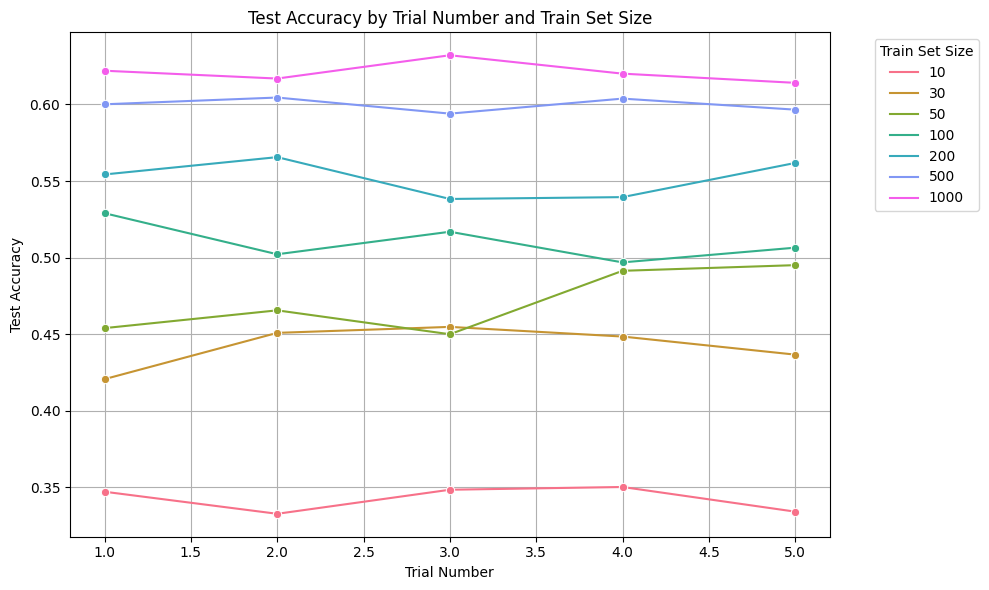

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


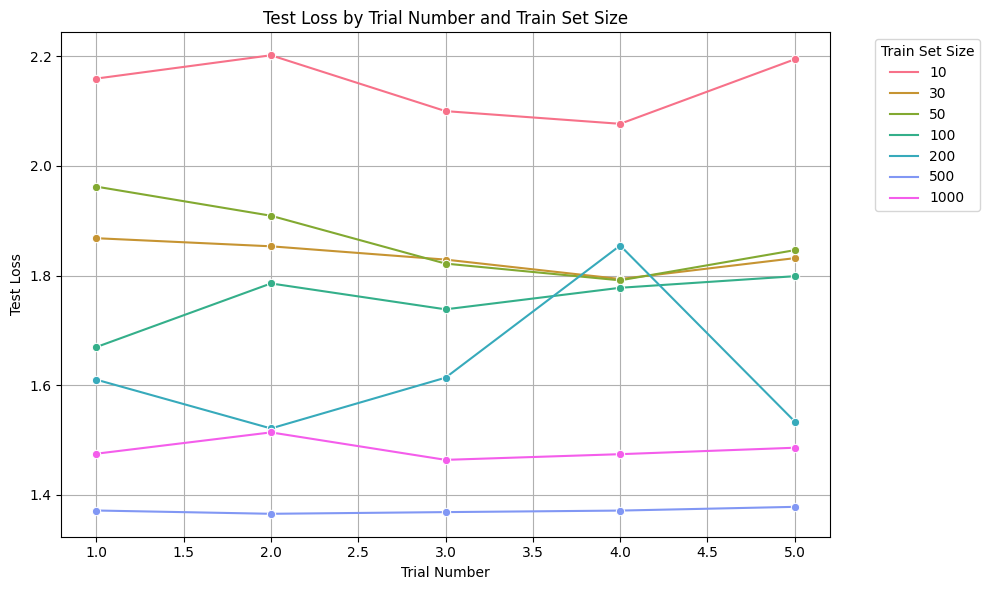

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame
columns = ['Trial Number', 'Train Set Size', 'Test Accuracy', 'Test Loss']
df = pd.DataFrame(logs_data, columns=columns)

# Display table
print(df)

# Import color palette generator for unique hues
unique_train_sizes = df['Train Set Size'].unique()
palette = sns.color_palette("husl", len(unique_train_sizes))

# Plot for Test Accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Trial Number', y='Test Accuracy', hue='Train Set Size', palette=palette, marker='o')
plt.title('Test Accuracy by Trial Number and Train Set Size')
plt.xlabel('Trial Number')
plt.ylabel('Test Accuracy')
plt.legend(title='Train Set Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for Test Loss
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Trial Number', y='Test Loss', hue='Train Set Size', palette=palette, marker='o')
plt.title('Test Loss by Trial Number and Train Set Size')
plt.xlabel('Trial Number')
plt.ylabel('Test Loss')
plt.legend(title='Train Set Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()